In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

#loading the data
path_data = 'behaviour_EEG_syn/'

# Across subjects

In [3]:
#weights_fitted_subjects.shape

In [4]:
# np.save('weights_fitted_subjects.npy', weights_fitted_subjects)
weights_fitted_subjects = np.load('weights_fitted_subjects.npy')
print(weights_fitted_subjects.shape)

(15, 4, 3, 500)


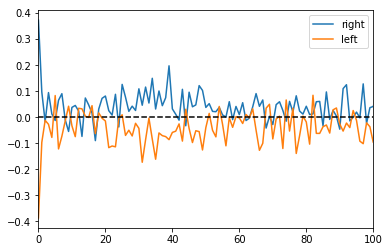

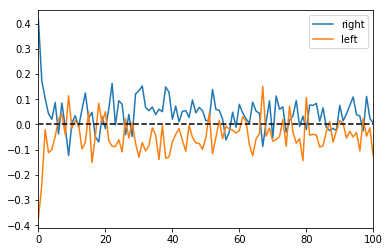

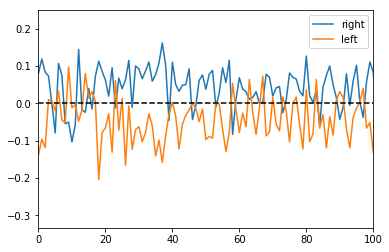

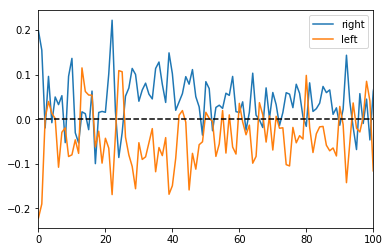

In [5]:
subjects = [16,18,19,20,21,24,26,28,32,34,35,40,41,51,52] #there are 15 subjects
sessions = [1,2,3,4,5,6] #6 sessions by subject (with 4 conditions each)

nsubjects = len(subjects) #15
nsessions = len(sessions) #6
nconditions = 4 #number of conditions

last_dim_truncate = 29490 #minimum (on all the subjects and sessions) of the number of time bins in a {session,condition]
nframes = 500 #number of frames taken (to go back in time)


weights_fitted_subjects_avg = np.mean(weights_fitted_subjects,axis=0)
for cond in range(4):
    weights = weights_fitted_subjects_avg[cond,:]
    weights_right = weights[2,:] 
    weights_left = weights[0,:]
    plt.plot(weights_right, label='right')
    plt.plot(weights_left, label='left')
    plt.legend()
    plt.xlim(0,100)
    plt.axhline(y=0,color='black',linestyle='--')
    plt.show()

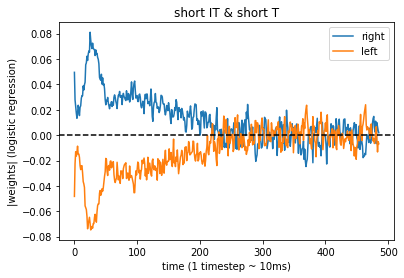

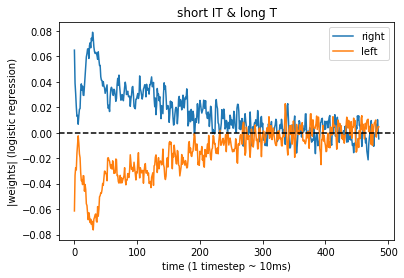

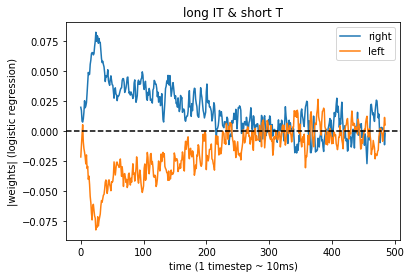

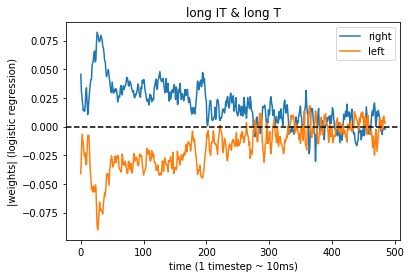

In [6]:
def moving_average(x, w): #in order to smooth the curve of the weights
    return np.convolve(x, np.ones(w), 'valid') / w

conditions_names = ['short IT & short T',\
                    'short IT & long T',\
                    'long IT & short T',\
                    'long IT & long T']


W = np.zeros((4, 486))

for cond in range(4):
    plt.title(conditions_names[cond])
    mov_average_value = 15
    
    weights = weights_fitted_subjects_avg[cond,:]
    weights_right = moving_average(weights[2,:],mov_average_value)
    weights_left = moving_average(weights[0,:],mov_average_value)
    
    # Save the weights to perform the fit 
    
    W[cond, :] = weights_right
    
    plt.plot(weights_right, label='right')
    plt.plot(weights_left,  label='left')
    plt.legend()
#     plt.xlim(0,100)
    plt.axhline(y=0,color='black',linestyle='--')
    plt.ylabel("|weights| (logistic regression)")
    plt.xlabel('time (1 timestep ~ 10ms)')
    plt.show()


## Fit it up 

In [126]:
from scipy.optimize import minimize
from lmfit          import minimize, Parameters
import numpy as np 


# The function minimize is going to look for the parameters which minimize the residuals (difference between the data and the function we want to fit the data to)
# the function expo is only defined to plot the results of the fits


def expo(x,a,inv_tau,b):                                                                                                                                                                                         
    return a*(np.exp(-x*inv_tau) + b )    # a ( exp(-x/t) + b ) I use 1/t (inv_tau), just take into account when working with the parameters and plotting 

# Get the maximum of the peaks
#params=scipy.optimize.minimize(llh_psycho_fit,x0=[0,1],args=(meanmix,y,n)).x


# I define parameters as dictionary
parameters = {}


def residual(params, x, data, eps_data):                                                                                                                                                                        
    '''                                                                                                                                                                                                         

    '''                                                                                                                                                                                                         

    
    # eps_data regulates the precision of the fit, do not care about it 
    
    #amp = params['amp']                                                                                                                                                                                         
    amp = 1.                                                                                                                                                                                          
    inv_tau = params['inv_tau']                                                                                                                                                                                 
    #offset = params['offset']                                                                                                                                                                                   
    offset = -0.2
    
    model = amp * (np.exp(-inv_tau * x ) + offset )                                                                                                                                                              

    residuo = (data - model)/eps_data                                                                                                                                                                           

    return residuo.astype(float)                                                                                                                                                                                


def residual_linear(params, x, data, eps_data):                                                                                                                                                                        
    '''                                                                                                                                                                                                         

    '''                                                                                                                                                                                                         

    a = params['a']                                                                                                                                                                                         
    b = params['b']                                                                                                                                                                                 

    model = a * x  + b                                                                                                                                                             

    residuo = (data - model)/eps_data                                                                                                                                                                           

    return residuo.astype(float)                                                                                                                                                                                




                          

###  Fit the data

In [127]:
# Exponential fit

eps_data = 0.001                                                                                                                                                                                                    
parameters = {}                                                                                                                                                                                                     
max_indexes = np.zeros(4)                                                                                                                                                                                                               
                                                                                                                                                                                                                    
for cond in range(4):          
    
    # I look for the maximum of the curves because we want to get rid of the hump at the beginning of the curves, which 
    # we don't understand (Hannah said that it might be due to motor preparation)
    
    
    max_ind = np.where(np.max(W[cond]) == W[cond])[0][0]  
    max_indexes[cond] = int(max_ind)
    
    #print(W[cond, max_ind])
    
    # Increase max_ind
    delta = 0
    max_ind = max_ind + delta   # here I just play with the number of points I use for the fits (e.g to start fitting after the initial fast decrease)
    
    
    
    # Initializing parameters, this is needed   
    # I first fitted for the three parameters and then fixed the value of the offset and amplitude (wise advice from Hannah)
    
    params = Parameters()                                                                                                                                                                                               
    #params.add('amp',value = 1.,  min = 0.9, max = 1.)                                                                                                                                                                                       
    params.add('inv_tau', value = 0.01)                                                                                                                                                                                  
    #params.add('offset', value = -0.29, min = -0.3, max = -0.28)                                                                                                                                                                                    
    #params.add('offset', value = 0., min = -np.inf, max = np.inf)                                                                                                                                                                                    

    
    # Normalize the weights!!! 
    w    = W[cond, max_ind: max_ind + 300]/W[cond,max_ind]                                                                                                                                                                            
    t    = np.linspace(0,300,300)                                                                                                                                                                                       

    pars = minimize(residual, params, args = (t, w, eps_data) )                                                                                                                                                         
    parameters[cond] = pars.params     
    
    

pars

    

In [27]:
# Linear fit

eps_data = 0.001                                                                                                                                                                                                    
linear_parameters = {}                                                                                                                                                                                                     
max_indexes = np.zeros(4)                                                                                                                                                                                                               
                                                                                                                                                                                                                    
for cond in range(4):          
    
    max_ind = np.where(np.max(W[cond]) == W[cond])[0][0]  
    max_indexes[cond] = int(max_ind)
    
    # Increase max_ind
    max_ind = max_ind + 50 
    
    # Initializing parameters                                                                                                                                                                                           
    params = Parameters()                                                                                                                                                                                               
    params.add('a',value = -1., min = -np.inf, max = 0.)                                                                                                                                                                                       
    params.add('b', value = W[cond, max_ind], min = 0, max = 1.5*W[cond, max_ind])                                                                                                                                                                                  

    w    = W[cond, max_ind: max_ind + 300]                                                                                                                                                                              
    t    = np.linspace(0,300,300)                                                                                                                                                                                       

    pars = minimize(residual_linear, params, args = (t, w, eps_data) )                                                                                                                                                         

    linear_parameters[cond] = pars.params     
    
    

### Save the parameter values

In [129]:
# Exponential parameters 


taus = np.zeros(4)       # Time constant
amps = np.zeros(4)       # Amplitudes
offsets = np.zeros(4)    # Offset

for i in range(4):
    #amps[i] = parameters[i]['amp'].value
    #offsets[i] = parameters[i]['offset'].value
    taus[i] = parameters[i]['inv_tau'].value**(-1)
    
print(offsets)
print(taus)
print(amps)

for i in range(4):
    #print(parameters[i]['amp'].stderr)
    #print(parameters[i]['offset'].stderr)
    print(parameters[i]['inv_tau'].stderr)

[0. 0. 0. 0.]
[146.61644048 168.44592201 179.83829592 208.40478736]
[0. 0. 0. 0.]
0.0001521207101585574
0.0001400307230581431
0.0001210552342521758
0.00012744909656509443


In [29]:
# Linear parameters 


slopes = np.zeros(4)   # 
oos = np.zeros(4)      # intercept

for i in range(4):
    slopes[i] = linear_parameters[i]['a'].value
    oos[i]    = linear_parameters[i]['b'].value
 
                                    

### Plot the parameter values

In [123]:
# Plot parameters with errors 


slopes_stderr = np.zeros(4)
oos_stderr    = np.zeros(4)

taus_stderr   = np.zeros(4)
amps_stderr   = np.zeros(4)
offset_stderr = np.zeros(4)



for cond in range(4):
    slopes_stderr[cond] = linear_parameters[cond]['a'].stderr
    oos_stderr[cond]    = linear_parameters[cond]['b'].stderr
    taus_stderr[cond]   =        parameters[cond]['inv_tau'].stderr *taus[cond]**2
    amps_stderr[cond]   =        parameters[cond]['amp'].stderr
    #offset_stderr[cond] =        parameters[cond]['offset'].stderr
    
    
    
conds_names = ['SIT ST', 'SIT LT ', 'LIT ST', 'LIT LT']
    

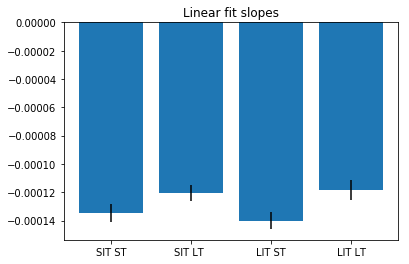

In [31]:
plt.title('Linear fit slopes')
plt.bar(np.arange(4), slopes, yerr = slopes_stderr, tick_label = conds_names)
plt.show()

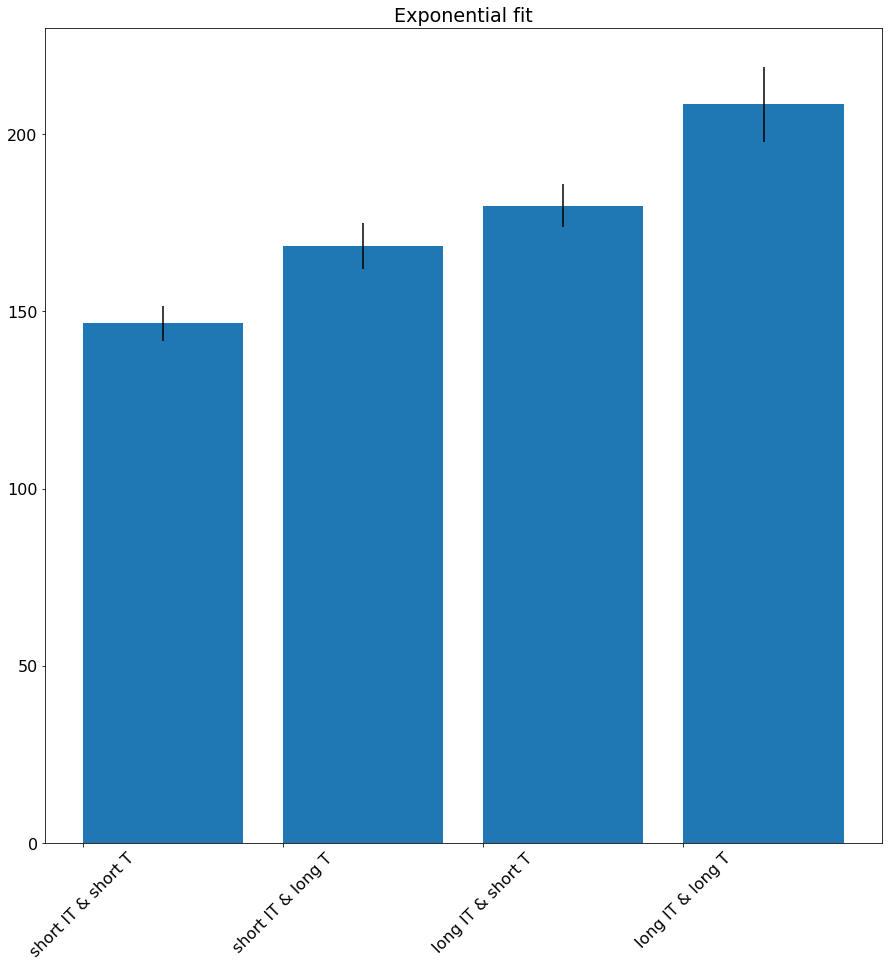

In [179]:
plt.rcParams.update({'font.size': 16, 'font.weight': 'normal'})  
plt.figure(figsize= (15,15))


plt.title('Exponential fit')
plt.bar(np.arange(4), taus, yerr = taus_stderr, align = 'edge', tick_label = conditions_names)
plt.xticks(rotation = 45)
plt.savefig('time_constants.png')

plt.show()


    
#plt.bar(np.arange(4), slopes)

In [165]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(*args, **kwargs)
    Make a bar plot.
    
    Call signatures::
    
       bar(x, height, *, align='center', **kwargs)
       bar(x, height, width, *, align='center', **kwargs)
       bar(x, height, width, bottom, *, align='center', **kwargs)
    
    The bars are positioned at *x* with the given *align* ment. Their
    dimensions are given by *width* and *height*. The vertical baseline
    is *bottom* (default 0).
    
    Each of *x*, *height*, *width*, and *bottom* may either be a scalar
    applying to all bars, or it may be a sequence of length N providing a
    separate value for each bar.
    
    
    Parameters
    ----------
    x : sequence of scalars
        The x coordinates of the bars. See also *align* for the
        alignment of the bars to the coordinates.
    
    height : scalar or sequence of scalars
        The height(s) of the bars.
    
    width : scalar or array-like, optional
        The width(s) of the

### Plot the fits


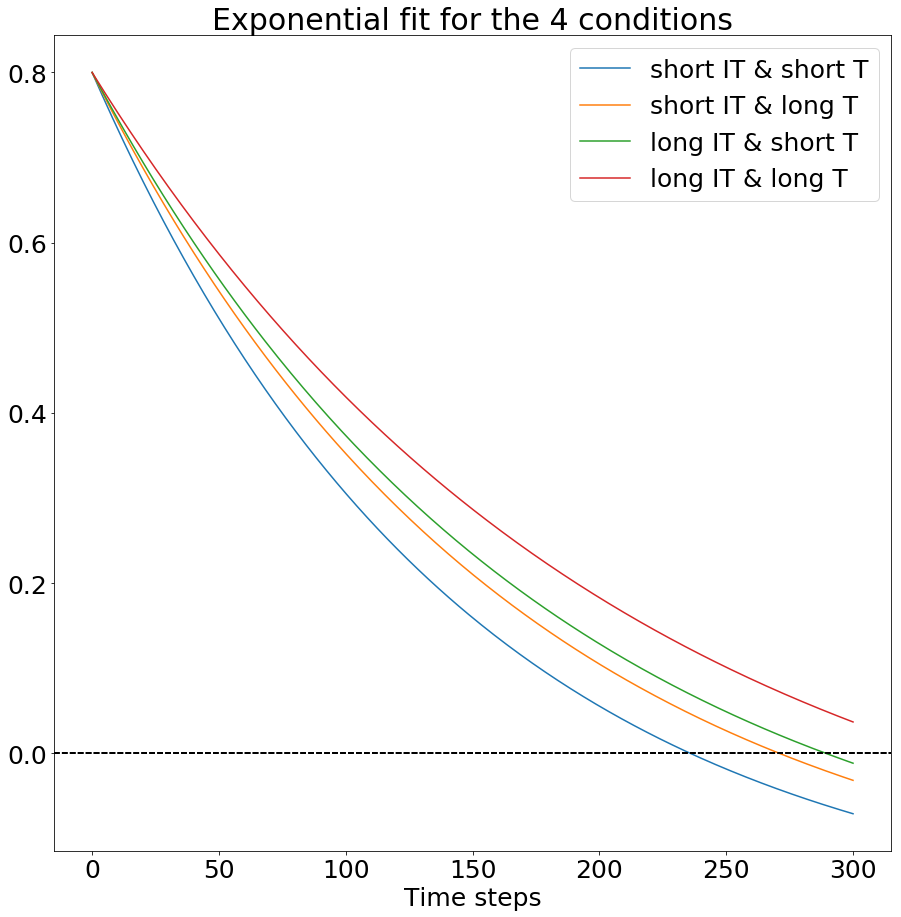

In [182]:
max_indexes = max_indexes.astype(int)


plt.rcParams.update({'font.size': 25, 'font.weight': 'normal'})  
plt.figure(figsize= (15,15))

for cond in range(4):
    #plt.title()

    plt.title('Exponential fit for the 4 conditions')
    plt.xlabel('Time steps')
    #plt.plot(W[cond, max_indexes[cond]:max_indexes[cond]+300 ]/W[cond, max_indexes[cond]])
    plt.plot(t, expo(t,1. ,parameters[cond]['inv_tau'].value, -0.2),\
             label = '%s' %conditions_names[cond])
    
    plt.axhline( y = 0, color = 'black', linestyle = '--')
    
    plt.legend()

    
plt.savefig('4fits.png')
    

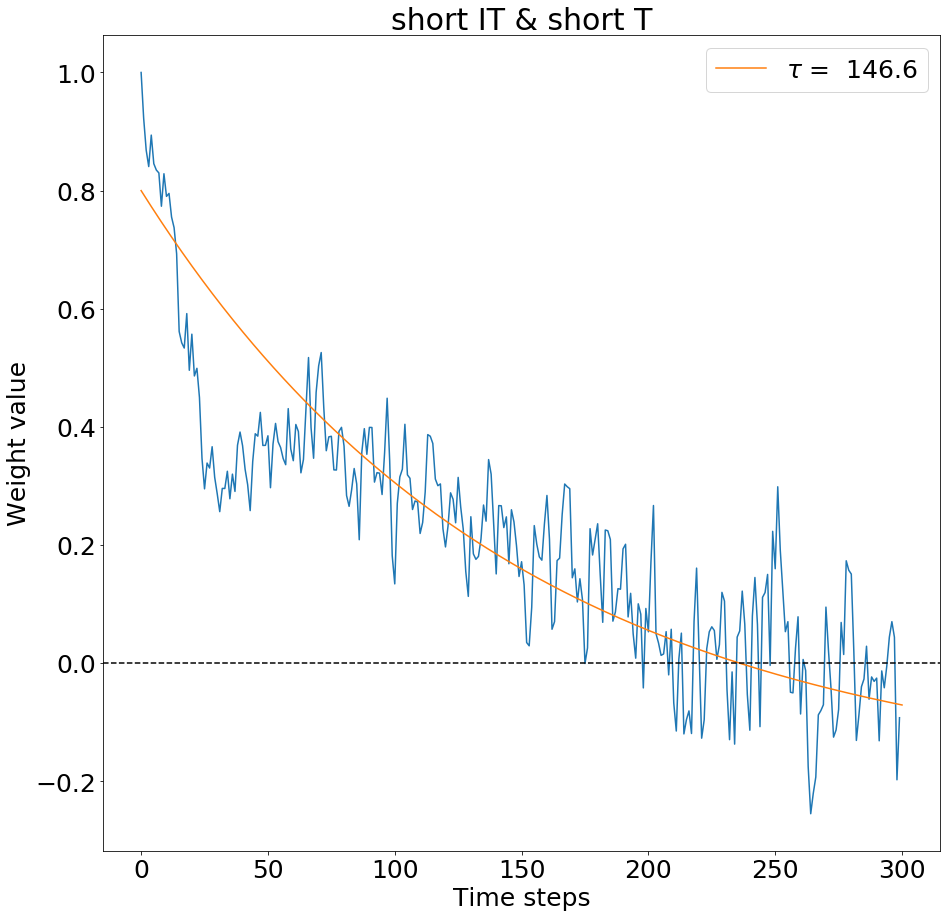

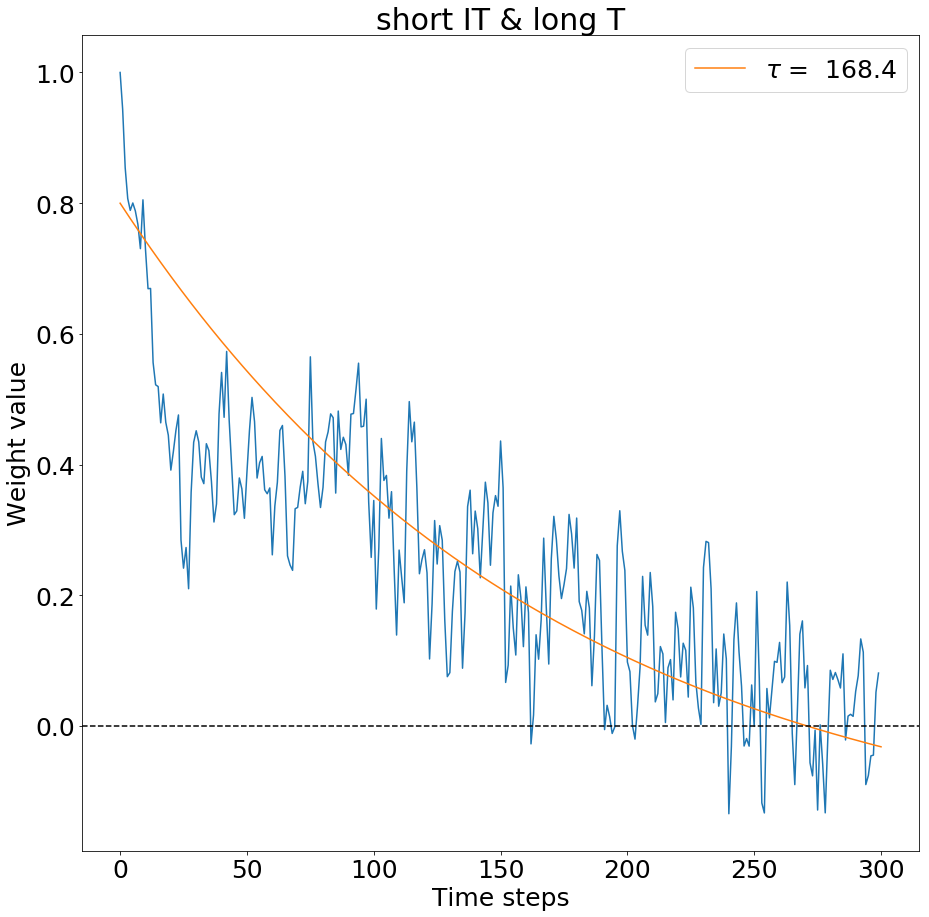

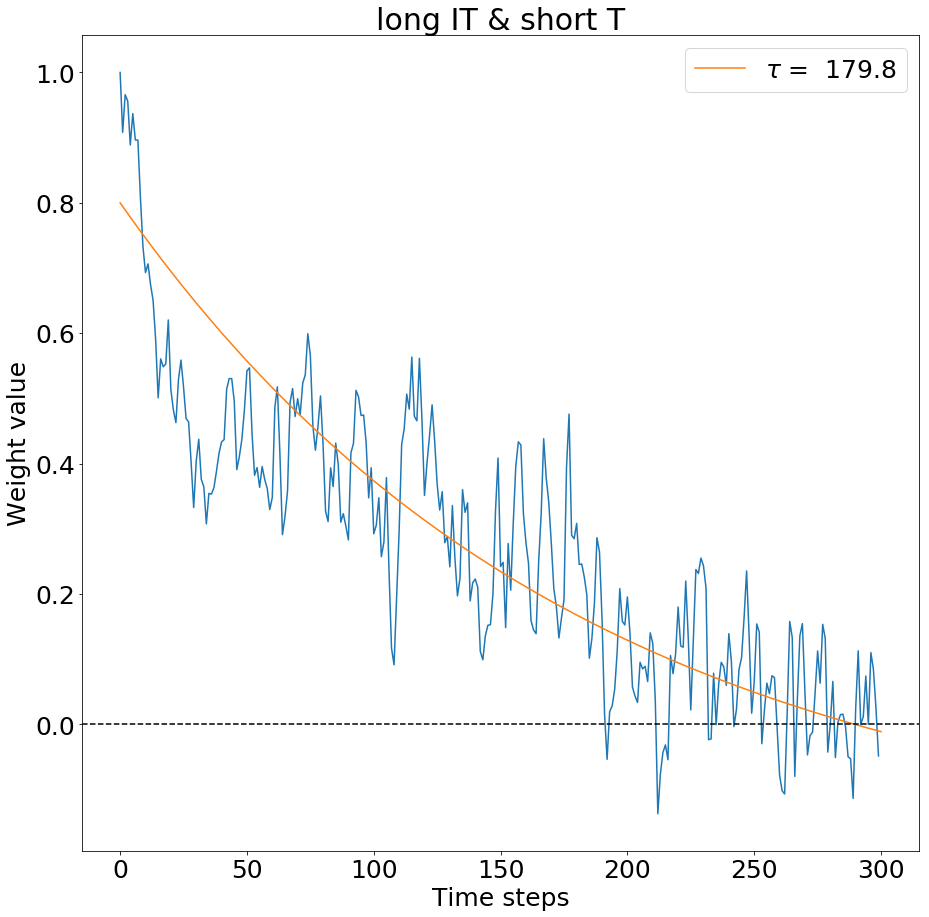

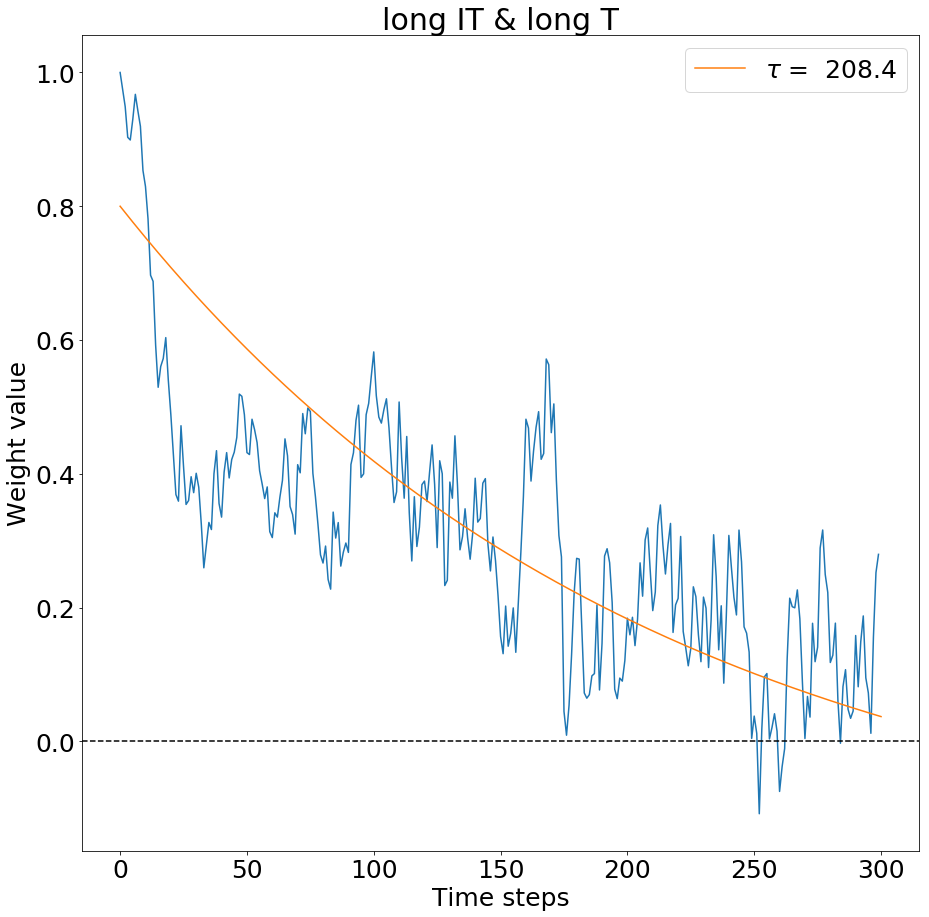

In [184]:
max_indexes = max_indexes.astype(int)


plt.rcParams.update({'font.size': 25, 'font.weight': 'normal'})  

for cond in range(4):
    plt.figure(figsize= (15,15))

    plt.title(conditions_names[cond])
    plt.xlabel('Time steps')
    plt.ylabel('Weight value')
    
    plt.plot(W[cond, max_indexes[cond]:max_indexes[cond]+300 ]/W[cond, max_indexes[cond]])
    plt.plot(t, expo(t,1. ,parameters[cond]['inv_tau'].value, -0.2),\
             label = r"$ \tau$ =  %.1f" %  ( np.round(parameters[cond]['inv_tau'].value**(-1.), 1)) )
    plt.axhline( y = 0, color = 'black', linestyle = '--')
    plt.legend()
    plt.savefig('fit_condition%d.png' %cond)

    plt.show()
    

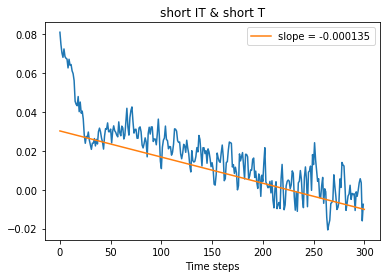

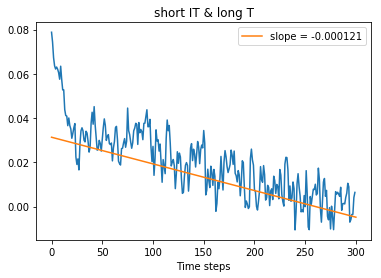

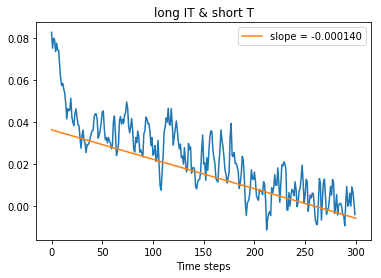

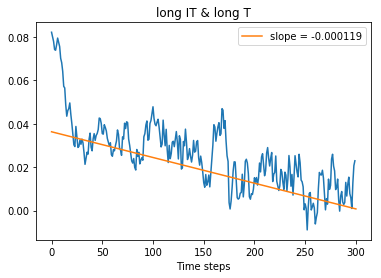

In [34]:
#  Plot the linear fits 

max_indexes = max_indexes.astype(int)



for cond in range(4):
    plt.title(conditions_names[cond])
    plt.xlabel('Time steps')
    plt.plot(W[cond, max_indexes[cond]:max_indexes[cond]+300 ])
    plt.plot(t, slopes[cond]*t + oos[cond], label = 'slope = %f' %slopes[cond])
    plt.legend()
    plt.show()

In [101]:
intersections = np.array(-oos/slopes)

print(intersections)

[248.94063852 279.03010869 276.75562333 334.15260092]


In [142]:
permutations = 1000

delta_par = np.zeros(6)
pvals     = np.zeros(6)

p = pvals     +  1

type( (p > pvals).astype(int))

numpy.ndarray

In [ ]:
help(np.random.shuffle)

for perm in range(permutations):
    Wper = np.zeros(W.shape)
    
    for i in range(W.shape[1]):
        Wper[:,i] = np.random.permutation(W[:,i])
        
    
    # Fit data to Wper for the 4 conditions
    for cond in range(4):          
    
    max_ind = np.where(np.max(W[cond]) == W[cond])[0][0]  
    max_indexes[cond] = int(max_ind)
    print(W[cond, max_ind])
    
    # Increase max_ind
    max_ind = max_ind + 10 
    
    # Initializing parameters                                                                                                                                                                                           
    params = Parameters()                                                                                                                                                                                               
    params.add('amp',value = W[cond, max_ind], min = 0, max = 1.5*W[cond, max_ind])                                                                                                                                                                                       
    params.add('inv_tau', value = 0.01)                                                                                                                                                                                  
    params.add('offset', value = 0., min = -1., max = 1.)                                                                                                                                                                                    

    w    = W[cond, max_ind: max_ind + 300]                                                                                                                                                                              
    t    = np.linspace(0,300,300)                                                                                                                                                                                       

    pars = minimize(residual, params, args = (t, w, eps_data) )                                                                                                                                                         

    parameters[cond] = pars.params     
    
    
    delta_par_perm = np.zeros(6)
    pvals          = pvals + (delta_par < delta_par_perm).astype(int)
    
    
    
    
    

In [144]:
print(Wper)

[[ 0.01985667  0.01714967  0.03055366 ...  0.01025758  0.00361565
  -0.00489444]
 [ 0.04950441  0.03070068  0.00823933 ...  0.00673366  0.00344746
  -0.00230024]
 [ 0.04548341  0.03886216  0.0223897  ... -0.00230665 -0.00063291
   0.00193581]
 [ 0.06477395  0.02780101  0.02457176 ... -0.00117372 -0.01150186
  -0.00174346]]


In [12]:
for cond in range(4):
    mov_average_value = 15
    weights = weights_fitted_subjects_avg[cond,:]
    weights_right = moving_average(weights[2,:],mov_average_value)
    weights_left = moving_average(weights[0,:],mov_average_value)
    
    #print(weights_right.size)
#     plt.plot(weights_right, label='cond = '+str(cond)+" , right")
    plt.plot(weights_right, label='cond = '+str(conditions_names[cond])+" , right")
#     plt.plot(-weights_left, label='cond = '+str(cond)+" , left")
    plt.plot(-weights_left, label='cond = '+str(conditions_names[cond])+" , left")
#     plt.plot(weights_left, label='left')
    plt.legend()
    plt.xlim(0,300)
    plt.axhline(y=0,color='black',linestyle='--')
    plt.xlabel('time (1 timestep ~ 10ms)')
    plt.ylabel("|weights| (logistic regression)")
    plt.show()data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAZoAAAEGCAYAAABcolNbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOy9d5ycZbn//76nz+7MbE+y2U2ym05IhRBCDwRBBESQIiCIcEQUjiJHUL+xopyfHjmKIMYjChy6KNIEDx1iACEJhPReN9leZqfutPv3x/1M2ZpJdmZ3k9zv12teM/PU+5nZfT5zlfu6hJQSjUaj0WjyhWm4B6DRaDSaIxstNBqNRqPJK1poNBqNRpNXtNBoNBqNJq9oodFoNBpNXrEM9wCGkvLycllTUzPcw9BoNJrDilWrVrVIKSsOdf+jSmhqampYuXLlcA9Do9FoDiuEELsHs792nWk0Go0mr2ih0Wg0Gk1e0UKj0Wg0mrxyVMVoNJr+iEaj1NXVEQ6Hh3soGs2w4XA4qK6uxmq15vS4Wmg0GqCurg63201NTQ1CiOEejkYz5EgpaW1tpa6ujtra2pweW7vONBogHA5TVlamRUZz1CKEoKysLC9WvRYajcZAi4zmaCdf/wPDKjRCiE8LITYLIbYJIb7bx3ohhLjXWL9GCHFcxrpvCSHWCyHWCSGeFEI4hnb0A/PPrc3sbAkM9zA0Go1m2Bk2oRFCmIH7gfOAGcCVQogZPTY7D5hiPG4Elhr7VgHfAOZLKWcCZuALQzT0rPiPpz/h/re2DfcwNEc51113HX/961/zcmyXyzWo/d9++23ee++9Ptc9/PDD3HLLLdx1113MnTuXuXPnYjabU6/vvffeXvu8+OKLzJgxg5kzZ7JkyZKDHssFF1xwSNeROeb9+/f3Wn7zzTczd+5cZsyYgdPpTF3DoX4v+/fv59JLLz3gdv19P8899xwbNmw4pHMfKsOZDLAA2Cal3AEghHgKuAjI/AQuAh6Rqjvbv4QQxUKISmOdBXAKIaJAAdD7Gx5GAl0xGjt1BpNG0xexWIy3334bl8vFySef3O92S5YsSYmGy+Vi9erV/W5766238vrrr1NbW8vOnTtzPuaBiMfjPPzww8ycOZOxY8d2W3f//fcDsGvXLi644IIBr+FAxGIxxo4dO6gfD8899xwXXHABM2b0/F2fP4bTdVYF7M14X2csO+A2Usp9wN3AHqAe8EopX+3rJEKIG4UQK4UQK5ubm3M2+IGQUhKKxmn2dQ3J+TRHBo888gizZ89mzpw5XHPNNQDs3r2bxYsXM3v2bBYvXsyePXsAZal84xvf4OSTT2bixImpG4+UkltuuYUZM2Zw/vnn09TUNOhx1dfXc/rppzN37lxmzpzJP//5z9S6JUuWMGfOHBYuXEhjY+MBx3zbbbdx5plncsUVV/D73/+eX//618ydO7fbMQ8Vm81GXV0dwIBZU++8807Kqpg3bx4+nw8Av9/PpZdeyvTp07n66qtJdh9+4403mDdvHrNmzeL666+nq0v9X9fU1HDnnXdy6qmn8uSTT7Jy5Uquvvpq5s6dSygUGvT1JHn44Ye57LLLuPDCCznnnHPYtWsXM2fOBCAYDHL55Zcze/ZsrrjiCk488cRuZbZ6fj/vvfceL7zwArfffjtz585l+/btORvnQAynRdNX1KlnX+k+txFClKCsnVqgA/iLEOKLUsrHem0s5R+APwDMnz9/SPpWR+IJEhItNIcpP3lxPRv2d+b0mDPGevjRhcf2u379+vXcddddvPvuu5SXl9PW1gbALbfcwrXXXsuXvvQlHnzwQb7xjW/w3HPPAUoAli9fzqZNm/jsZz/LpZdeyrPPPsvmzZtZu3YtjY2NzJgxg+uvv77X+X75y1/y+OOP91p++umn93JLPfHEE5x77rksWbKEeDxOMBgEIBAIsHDhQu666y7uuOMOHnjgAb7//e8POOYtW7bw+uuvYzab+fGPf4zL5eLb3/72oX2oGSQSCY455hiuv/56Xn311QGF5u677+b+++/nlFNOwe/343Co8O7HH3/M+vXrGTt2LKeccgrvvvsu8+fP57rrruONN95g6tSpXHvttSxdupRbb70VUPNOli9fDsAf//hH7r77bubPnz/o6+nJ+++/z5o1aygtLWXXrl2p5b/73e8oKSlhzZo1rFu3jrlz56bW9ff9fPazn+WCCy7Iyv2WK4bToqkDxmW8r6a3+6u/bc4Gdkopm6WUUeBvQP/29xATjiYAaAtGiMYTwzwazeHAm2++yaWXXkp5eTkApaWlgLrBXHXVVQBcc801qZsawOc+9zlMJhMzZsxIWRPLli3jyiuvxGw2M3bsWM4666w+z3f77bezevXqXo++Yh8nnHACDz30ED/+8Y9Zu3YtbrcbUBZEMq5x/PHHp26AA435sssuw2w2H/Ln1B/33Xcfxx57LEuXLuXCCy+kubmZDz/8kMsuu6zXtqeccgq33XYb9957Lx0dHVgs6vf2ggULqK6uxmQyMXfuXHbt2sXmzZupra1l6tSpAHzpS19i2bJlqWNdccUVOb+WvvjUpz6V+pvIZPny5XzhCyo8PXPmTGbPnp1a19/3MxwMp0WzApgihKgF9qGC+Vf12OYF4BYjfnMiykVWL4TYAywUQhQAIWAxMGLKMoejcQCkhLZAhNGeEZUQpzkAA1ke+UJKmVVqaeY2dru92/59bdMfB2PRnH766SxbtoyXXnqJa665httvv51rr70Wq9WaOpfZbCYWix1wzIWFhQcc26HwyiuvcMcdd7Bo0SJ++MMfcv7557NgwYI+heC73/0u559/Pi+//DILFy7k9ddfB7p/nsnryfxc+yJf15PteQYaX7bfz1AwbBaNlDIG3AK8AmwEnpZSrhdC3CSEuMnY7GVgB7ANeAD4urHvB8BfgY+Atajr+MPQXkH/hCLx1OumTu0+0xyYxYsX8/TTT9Pa2gqQcp2dfPLJPPXUUwA8/vjjnHrqqQMe5/TTT+epp54iHo9TX1/PW2+91ed2B2PR7N69m1GjRvGVr3yFG264gY8++mjAMWQ7ZrfbnYqPDJZ58+bx2GOPkUgkuPzyy5kyZQpPPPEE559/fq9tt2/fzqxZs/jOd77D/Pnz2bRpU7/HnT59Ort27WLbNpVB+uijj3LGGWfk5XqeffZZvve97x3UPqeeeipPP/00ABs2bGDt2rUH3CeXn3u2DOs8Ginly1LKqVLKSVLKu4xlv5dS/t54LaWUNxvrZ0kpV2bs+yMp5XQp5Uwp5TVSyhFzRw9F00LT7NeZZ5oDc+yxx7JkyRLOOOMM5syZw2233QbAvffey0MPPcTs2bN59NFH+c1vfjPgcS6++GKmTJnCrFmz+NrXvtbvTfFgePvtt1OB82eeeYZvfvObA26f7ZgvvPBCnn322ZwkAyxZsgQpJTNnzuT4449n9OjRfPWrX+Wqq64ikejuvr7nnnuYOXMmc+bMwel0ct555/V7XIfDwUMPPcRll13GrFmzMJlM3HTTTX1ue91113HTTTcdcjLA9u3b8Xg8B7XP17/+dZqbm5k9eza/+MUvmD17NkVFRQPu84UvfIFf/vKXzJs3b8iSAcSBTMMjifnz58uhaHz20Z52Lvmdmh/wi8/P4ooTxuf9nJrBsXHjRo455pjhHobmKOaLX/wiv/71r6moyL6RZTweJxqN4nA42L59O4sXL2bLli3YbLZDHkdf/wtCiFVSykPOctBFNfNAOKpdZxqN5uB47LFeSbMHJBgMcuaZZxKNRpFSsnTp0kGJTL7QQpMHwt1cZ1poNBpNfnC73YdFe3pdVDMPhCLKJ3y6aS1FjR8O82g0Go1meNEWTR5IJgM8Yvv/1Kyf0CXgLB7eQWk0Gs0woS2aXNC0ER69BCKqWrNynWUkWSz/1fCMS6PRaEYAWmhywe73YPsbUP8JoISmgo7UarniT7DmL7D0VIjqdGeNRnN0oYUmF4S96rl5M6AmbI4Xqpjh72MXIiJ+5PM3Q+NaaNk8XKPUHIXoNgHZj2WktgnIdmxXXnkls2fP5te//nW/YxkudIwmF3QZBRhbtgAqRlNrVpWi/xI/nWs9qygIqi/du2ctRZVzhmWYGs1IQbcJyC0NDQ2899577N69G4BFixb1OZbhQls0uSBp0RhCE44mqDW3IBHUyQpWVV5JnWMqUWnGt3fdMA5UM5LRbQIGx5HaJiCTQCDA9ddfzwknnMC8efN4/vnnATjnnHNoampi7ty5/PSnPx2SsRwM2qLJBWHDomlOWzTjTU0I91jcFjcvOi9id8mn+FnwBhxN/ddV0owQ/vFdaDhwzaiDYswsOO/n/a7WbQIGx5HeJiDJXXfdxVlnncWDDz5IR0cHCxYs4Oyzz+aFF17oZi298cYbeR/LwaAtmlyQtGi8eyASJByNM040QUkNE8oK2N0aZHdrkC2yigLv1uEdq2ZEotsEDI4jvU1AkldffZWf//znzJ07l0WLFhEOh1MW40hGWzS5oCujSVbLFkKROFWyEYrnMlW6ePGTevxdMbZaqjmvayVsfxNqzwBT7v/hNDlgAMsjX+g2AYPjSG8TkERKyTPPPMO0adO6LR/OXjPZoC2aXBD2wuhZ6vX+j+mKRCiV7VBUzUmTyvF3qX/AzWIiJhLw6MWwve/y7ZqjE90mYHAcLW0Czj33XO67776UAH788cd5GUuu0UKTC8JeGDsHCsph74c4u5oxkwDPWE6eVJbaLFhzNtdFvqPetO1I7x8JQnT4A3aa4UO3CdBtArJpE/CDH/yAaDTK7NmzmTlzJj/4wQ/yMpZco9sE5IK7xsL8L0PbTmjexB3xr/Ff3m/DVX+Bqedw3m/+ycb6Tu686Fh++Pw6thdej/nEG+Gcn6n9n7wSEHDlE7kfmyYrdJsAzXBzKG0C8kE+2gRoi2awxKMQDYCjCMYtgLbtjOtSZjZFVQCcN3MM40sLuOz4cUwsd7EvUUa4xQjgJeKwc1l3C0ej0Rx1PPbYY8MuMvlCJwMMli7DD2r3gDER85SIkWXjUZOlbjlzMjedMQmbxcR/Xz6HvX8so2PLBuwNPry7V7Mg4odQ23CMXqPRaPKOtmgGS9ioaeYogrFzwWRlbmI9EeEAh6rYbDIJbBb1Uc8bX8LMGTMYLZt5dX0Dr736d7V/sA2OIjfmSORociNrNH2Rr/8BLTSDJTmHxlGEL25hq3kSJiSdtlHQT5pp0ZiJjBYd7GhoY1KXkfGSiELEP0SD1vTE4XDQ2tqqxUZz1CKlpLW1NTWBNZdo19lgSVYFcHh4f3sre0K1TLFswmutoLy/fYrGAbBjxxZuNG1PLw+2gd2d1+Fq+qa6upq6ujqam5uHeygazbDhcDiorq7O+XG10AyWDIvmX2vbaJLTgH8QKRjT/z5F6ossCu1lsnU/mxPVTDPVQagdSibkf8yaXlit1gHLlmg0mkNHu84GS7IqgKOID3a2kqheAMCUydP638cQmtNNa7CKOB8kVCrhhu278jlSjUajGRYOKDRCiFFCiIuFEDcLIa4XQiwQQmiBSmJYNF5ZyIb6TqZOmQKXPIDlxBv636d4AhGLi4vNKjtttelYAJb+Y4WOEWg0miOOfgVDCHGmEOIV4CXgPKASmAF8H1grhPiJEGLgaaxHA8FWMFlY2xxHSpg/oRRmX56yWvrEbME/5kTKhI8YZs5YrMpkFAs/+726A6dGozmyGChG8xngK1LKXqVBhRAW4ALgU8AzeRrb4YF3H7jHss8QiAllBVntZpq0COreoMk2jotOnQdvQQl+Nu7vpKrYmccBazQazdDSr0Ujpby9L5Ex1sWklM9JKY9ukQFk5z5irkr2tYcwCRhTlF1qoHu6Kt/e6ZkKZivS7qZE+NhY33mAPTUajebw4oBZZ0IIO/B5oCZzeynlnfkb1uGDr2k37wbHsb0wwGiPA6s5u/CVefQMQuPPoPa4ywEQzlKqYmGe1UKj0WiOMLK5Kz4PXATEgEDGY9AIIT4thNgshNgmhPhuH+uFEOJeY/0aIcRxGeuKhRB/FUJsEkJsFEKclIsxHRRS4gw1sCdWzPKtLYw9GJeXyYTz+hewzzUaMxWUMtYe0haNRqM54shmHk21lPLTuT6xEMIM3I+K89QBK4QQL0gpN2Rsdh4wxXicCCw1ngF+A/yflPJSIYQNyC44kkuCbVhlhHpZhjcUHVxsxVlKha+RXc1BdrcGmFA2tA2VNBqNJl9kY9G8J4SYlYdzLwC2SSl3SCkjwFMoyymTi4BHpOJfQLEQotLIdjsd+BOAlDIipezIwxgHprMOgHqp2u4elEXTk4JSykw+zCbBEx+M/NasGo1Gky3ZCM2pwCrDxbVGCLFWCLEmB+euAvZmvK8zlmWzzUSgGXhICPGxEOKPQoghNwGkdx8A9VI1N6sqGYTQuMdg8TfwqemjeHrlXrpi8VwMUaPRaIadbIQm6b46B7gQldZ8YQ7O3VfFyZ6zFfvbxgIcByyVUs5DxYx6xXgAhBA3CiFWCiFW5rqOVbhVaWAjyqKpKh5EMbqi8RDv4pLpNtqDUbY26gKbGo3myOCAQiOl3A0Uo8TlQqDYWDZY6oBxGe+rgf1ZblMH1EkpPzCW/xUlPL2QUv5BSjlfSjk/102FAs27iUoz48fVqMGVDCJMVKwu8xin8gBubRo5/b41Go1mMGRTguabwOPAKOPxmBDi33Nw7hXAFCFErRHM/wLwQo9tXgCuNbLPFgJeKWW9lLIB2CuESBYUWwxsYCiREtvud9gmq7jl7Gn87HMzmTLKdejHMyoJVNKK1SzYoi0ajUZzhJBN1tkNwIlSygCAEOIXwPvAfYM5sZQyJoS4BXgFMAMPSinXCyFuMtb/HngZVaFgGxAEvpxxiH8HHjdEakePdflnz/t42tfx8/gNfHOMmzOmDtJaMloHWHx11JbPZmujtmg0Gs2RQTZCI4DMyHScvmMnB42U8mWUmGQu+33Gawnc3M++q4H5uRjHIfGvpYQsHl6MnsbPXPbBH89RBDY3eOuYMuoU1u33Dv6YGo1GMwLIRmgeAj4QQjxrvP8cRlrxUYu/GTa/zCv2z1LlKsNkyoHuCqHiNB17mTLaxcvr6glF4jht5sEfW6PRaIaRbJIBfoVyS7UB7cCXpZT35HtgI5o1f4ZEjPs7FnLJcT0zsgdBUTV49zJllBspYUeLjtNoNJrDn34tGiGER0rZKYQoBXYZj+S6UillW/6HN0JZ/yz7C2ewIzKOz83LpdCMg70fUuGyAdAeiObu2BqNRjNMDOQ6ewI1Z2YV3ee3COP9xDyOa2QTaGaHnMzMqiJGuQcxd6YnY+fByj8xqv0jAHxhLTQajebwZ6A2ARcYz7VSyokZj1op5dErMgDRIIGEDY8jmxDXQTDz8+AsYfTa3zNV7MXXFcvt8TUajWYYyGYezSnJ8i5CiC8KIX4lhBif/6GNYKIhAtKG05rjQL2tAI7/Ms5dr/Oq/TtYm4d2apBGo9Hkg2xK0CwFgkKIOcAdwG7g0byOaiQjJUQC+OM2CvKREXb6t4kvWgKAydezUIJGo9EcfmQjNDFjPstFwG+klL8B3Pkd1ggm1gVIOhM2nLYcu84AbIWYZ31evQ4dvfkWGo3myCGbO6VPCPE94IvA6UYfGWt+hzWCiQYB8MUs+bFoAJwlAJi6hr7zgUaj0eSabCyaK4Au4AajxlgV8Mu8jmokYwiNN1+uMwBHEQkE5rAWGo1Gc/iTlUWDcpnFhRBTgenAk/kd1ggmooQmKO0U5MN1BmAyExCFWCO6DI1Gozn8ycaiWQbYhRBVwBuoKgEP53NQIxrDogmRR4sGCJjc2GNaaDQazeFPNkIjpJRB4BLgPinlxcCx+R3WCMYQmiD2vNYhC1k8OGOdeTu+RqPRDBVZCY0Q4iTgauAlY9lhWemxI5iDmfaG6ywk7Xm1aLqsRRTEdasAjUZz+JON0NwKfA941ugXMxF4K7/Dyg8dwcjgD5JyneVXaKLWIlxSC41Gozn8OWA0W0r5DvBOsjqAlHIH8I18DywfWGQuhcaG05qnZAAgZi/GI/0kEjI3bQg0Go1mmMimBM1JQogNwEbj/RwhxO/yPrI8UBpvHvxBkjEa6cirRZNwFFNEgGBEufv+uqqONzc15u18Go1Gky+y+Ul+D3Au8AKAlPITIcTpeR1VvpDywNsciMjQuM5wlGASkoC3Dde293julU7E6GM4a/ro/J1To9Fo8kA2MRqklHt7LIr3ueEIR5ADoYmGACO92Z4/15koVNUBQu0NyGe/ytfDf6A9FzEmjUajGWKyuVPuFUKcDEghhA0Vn9mY32Hli1wITYC4sBDDQkGuqzdnYCksBUDWf4yIRzjZtB67b1/ezqfRaDT5IhuL5ibgZlTpmTpgrvH+sEPkQGeIhoiZVLOzfM6jsbrKALDv/zC17Kyu1/J2Po1Go8kXA1o0RgHNa6SUVw/RePJMLmI0ASImJyYBdktWnsdDwlFSCYBn3zIAtiSqmM869rYFaQtEmDOuOG/nHlbe/jlseUU1gTv5luEejUajyQED3imllHFUe4AjglzFaCImVedMiPylHY+fOIN6KnAF6/Bby1mRmM5UUcdPXljHlx9ekbfzDjvr/gb7P4IP/zDcI9FoNDkim5/k7wohfiuEOE0IcVzykfeR5YHcCE2QLuHIq9sMwGw20ThmEQA7RTVbZDUlwo9tzzJOCi0jGDlC2zwHmtRzly6/o9EcKWSTDHCy8XxnxjIJnJX74eSXnAhNJECY/M6hSVK14CJ44S98FKxguxgHwH/Gf0WBNcy+1m9SW1me9zEMKfEohNrV63CnSkfPo9Wo0WiGhmwqA5w5FAMZCgSSeEJiHsxM+2iIMLb8tQjIoGLW2TS9eQzvtM2hwVELCSgWAQD8uz6CynPyPoYhJdiqnosnQMduiATA7hreMWk0mkFzwLulEOK2PhZ7gVVSytW5H1L+EEAklhic2ysaJIh7SCwarE4q/uN9TnhnB1dUFNL6tJsyoeqfiboPgSNMaPzKbdZiH0c5u5X7TAuNRnPYk02MZj4qxbnKeNwILAIeEELckb+h5R6BJBJLDO4g0SBBmd9eNJkIIfjaokmcNX0UmxPjaJZF1MlynE0fD8n584mUktc3NJJIGC7NgCoR9OK+QvU+rPvxaDRHAtkITRlwnJTyP6SU/4ESngrgdOC6PI4t5wgkXfFBFjWIBPElbDjzOFmzL6xmE/9t+jJfjXyLVYmpVHR8MqTnzwcf7Gzj3x5ZyYe72tSCQAsAO+UY9T6sEwI0miOBbIRmPJBZ+yQKTJBShoCuwZxcCPFpIcRmIcQ2IcR3+1gvhBD3GuvX9Mx2E0KYhRAfCyH+ntX5kESigxAaKUl0+WgKmZhdXXToxzlEmgun8JGcyg7rFDzRZgi2DfkYckljZxiAtoDx52VknO0yhCYSaB+WcWk0mtySjdA8AfxLCPEjIcSPgHeBJ422ARsO9cTGZND7gfOAGcCVQogZPTY7D5hiPG4ElvZY/00OshxOJDIIbezYjSkaYLscOyzFLUsKbbjtFiiZAMCfXnqHaHyQrsBhpNWvBKYzZDSkCzQTxcI+qbLpAt7DW0g1Go3igEIjpfwp8BWgA5UEcJOU8k4pZWCQFQMWANuklDuklBHgKXpPDr0IeEQq/gUUCyEqAYQQ1cD5wB8P5qTR6CCEpm4lAHsLZnBMpfvQj3OIVHoc1FYUknCrVOcPP/6ENXWHbxyjNaC+i86wEhrpb6ZZFuEpVuV3gj4tNBrNkUC2NVScQKeU8h5gtxCiNgfnrgIyq0LXGcuy3eYe4A5gwJ/0QogbhRArhRArAWJdhy40sm4lYWmlevoJea0K0B8/uehY7r/qOBrNFQBUi2Z2tgSGfBy5ImnR+MJq8mm4o4EW6WF6TTUAEb92nWk0RwLZND77EfAdVDtnACvwWA7O3deduueMyj63EUJcADRJKVcd6CRSyj9IKedLKecDRA/BdSal5OkVe4nsXsFaWcu0sSUHfYxcMNrjYFxpAVecNpuwcFIlWtjZ4h+WseSClh6us2hnE63Sw7yJlUSkmWiwYziHp9FockQ2Fs3FwGeBAICUcj+QC79RHTAu4301sD/LbU4BPiuE2IVyuZ0lhMhK/GKH4Dpbv7+TJc98hKlxDasTk6kpKzzoY+SS42vKcJTXMMXePvQWTSJ3MaG06ywGUmIONNAiizhxYhk+CogHD1+3oEajSZON0ESklBLD2jCSAHLBCmCKEKLW6HPzBYwunhm8AFxrZJ8tBLxSynop5feklNVSyhpjvzellF/M5qSHIjStgQinmNZhlRHeT8ygtnx4hQaA4nGMN7eyo3kIhWb3+/CfY8GXm5bS3ZIB2nZQGGlhh20a40oK8MkCPY9GozlCyEZonhZC/A8qEP8V4HXggcGeWEoZA24BXkFljj0tpVwvhLhJCHGTsdnLwA5gm3HOrw/2vIciNB3BCJ8xfUCndPKBmMPYYudghzF4isczKt7IrtZAesLjYOjYC49cBJ31/W9T9yHEQqo8TA5IpjV3hqOw7Q0A6itOxmQSBE2FmCJ6Ho1GcySQTa2zu4UQnwI6gWnAD6WUOenAJaV8GSUmmct+n/FacoAma1LKt4G3sz1n/BBiNO2+AJ8zr+S1xPGMKfUMrlZarigahzPuwxwN0NAZHrz4ffIk7Hgb1j8LJ/Wj52071HMOJlKGo3H8XSoJoDMUg+1vspcxOEdPUevNboqivkGfR6PRDD8DWjTGhMjXpZSvSSlvl1J+O1ciM1zED8GiMTdvolgEeDN+3MhwmwEUjwdgnGhmVy7iNBtfVM/bBvh623aq567Bu7RaDWvGbBIEQiHkrn/yTnwmJQVWAKJWF9bY0CU6/O7tbfz7k4d/WR+NZiSSTeOzoBBi6KfB54l4NHLgjXqQ8KuYRL0sHfZEgBSlEwGYIBpoCx78NXWjfTc0rAFHMexarqom90VSaA41dtK8GepV6ZxWvxL86hIn1V3bEBE/78VnUORUQhOzenDGh05oPtzZxvvbW7PbOBKElq35HZBGcwSRTYwmDKwVQvzJKAdzrxDi3nwPLF/EY4cwjyaoanCVjq7i1CkjpAdM2SQAaszBkY4AACAASURBVEUDHcHo4I618x31fOYSiEdgxzvpde/8Fzz7NYh1QWedWpal62xtnbd7/Oj+BfA/pwPpRIDa8kKOja0HYEViWkpoEg4PLplDodm1HJ68EhJ9lyBqC0TwhiIob+0BWPFHdR3xI7T5nEaTY7IRmpeAHwDLgFUZj8OSROzgf/1bDKH549fOY9G0Ubke0qFhdyMLR1EjGugYrEXTtgNMFjjuGigogzV/Tq/buQzWP0u4cRtII7U5i+6XO5r9XPjb5by+0chQa+peKajFsGhqygo5wbSFsHsCzZTgMYRGOMtw0kUsPIBbcMsrsPzX2V3jjndg88vga+hzdVsgQjQuCWVTC69zP0SDKjFCo9EckGxK0PxvX4+hGFw+OBShsXW1ERE2sI2s3iiidCITzU2Dt2jad0PROLA6Ydbl6oacLNgZbINYiI/eeDq9fabr7PHLYdndvQ7Z3NTIO7ZbCe78UC1Y90y39cmMs4nlBcw3baa+aC5AyqKxuJXl2NY8QBbc6sfhn1kKTdiY/NnZc6pW9/Fk9Vkmrz8azu7cGs1RTrYlaI4Y5CEIjTPaRsBSMvLaCpdNUq6z0GCFZheU1KjX865W7rONxpQmw5qr3qcKZMetrrTrTErlktrX28BN1K9mgqmJEzb8p1qw+R/q2eKEzv2M2f08DqtgInWUi0622o8F0kLjKFYVnDtaBhAaf7NKTOjKwsWWbBHt6y004WicYERZMgclNNqi0Wiy4qgTmoO1aKSUuGMdhG2leRrRICidSAVtBP2DTDfu2J0WmtEzAQHefUpIjPbK47u2sT4xAX/BuPSNtssH0QD+9kZW7OpeANNv1C+rCO2ARByZDJ7HQvDWXVy04ydc7FjN+GYVD3rf6ACRFJrCElUd29/Wt6sLSDVKwzeAGCVJCk0fFk2qTQHQEer772NfRyi9nbZoNJqD4qgTGhk/OKEJRuKU4CViL8vTiAaBkXnm9A1iAmWXT4mJ0XoAIZSLMBJQN9REOuD95/gifKIwHaMx4h3tLQ18729rux02FFBzYGyyCzr2IOJdbEoY1YSMhIzb4g9Ssedl1iRqWedX2XzJGE1ReSUAYW/fVQj+taOVWLJCQee+fi8v3NVFIBgk4leCuX7Txl4B/6SAeAjAvo/6PM5X/nclP/u70RUj6YbTFo1GkxXZFNV8TQhRnPG+RAjxSn6HlT8O1nXWFohQJjpJFIyQbLNMytXkxpLQru7LW7bCng+yO0a7EqndiYwkB1shRHwpayZm89AlrTwfPwVvwpl2nRmWRGHcy7YmfzfLIBpKT7aUm9Wc3LUJo+i3IVDFiQ6cret5I34cO5oDCIHqtwOUVIwFINLZ3GvIz6yq49oHlmNJVg7oJ+4CsGrpDWz9zQX4O5QLcNv2rWxt6u5qS477bfu3OPnNy/o8zp62IHUdhrAcyKIJe1PdQjUaTXYWTbmUMlVGV0rZDoyQ1KtD4CCEJp6QrN/XQTmdUFiRx0EdImVTiGNmdHhn9+WvLIHnbup7n5607wLgln+0sanBuHHbDYvGEJo7/FdxSeTHWF1ltMacEPayanc7kQ51gy8igIlEN/dZNJR258U/UvVO10hlgdGxhy2ihofH/ydyzCxeFqfRGojgcVgxGVUXrAXFRLFg8+3B//Zv2LS/PWWJ/Oq1LZSRkZAwgEXj9O6gKrwNa0RtP0a0pTLekrQFIlTQQakwBKhHCnwwEsPfFUvN/RkoRvP86n1s+NNNRB69vN8xaTRHG9kITUIIMT75Rggxgd7l/A8fEtkHzv+8Yi/ffvxd7CKK1TMCtdXqoMNRzfj47u7uoMZ14G/K7hhG3bI9chT/WGvEQ2yFKsBuCM1WWU1j4XQWTiylMWIjFurg80vfY+VaNf/FLCRl5iArdqaFJhFWN+0OWYileQOd0km7XfWZkZ37aIsX0FJ5GuKm5YgyJUDJ+AwAQtApPBzX8iKut3/Ikvse4t1trcTiCeq9IRZVZSRm9GPReENRHHE/ZXRSEFcW1hjaulleoITmCvNb6QU9Jqw2dSqBaQ1E1DycpOuwD4vmv/5vM6HGrQQbtuALDzJJQ6M5QshGaJYAy4UQjwohHkXNp/neAfYZuRxEjOa1DQ3M8Kjtx1aNO8DWw4PXPZkp7CVgZE0RbFO/8CP+rILV/tb9RKQZL4W8sj4pNMqikUaw/aSZU/i/W09jQlkB9V12LFE/Z5o+psC/K3WckysF/9zaQtyYoCkjSmieip8JwE5ZybhKJdYiEaNDFlJeaAdgglFtoZvQAAFLMQ6hbtY1opEtjT6afF0kJJxpfB0S0a/QbKrvxE0Qk5CYhSQqbIwRbbT7u1SmXFwduy0QYYF5c3rHru411pp8Smg6gtHuPXKiwfTr1U+Ct45IPEGlxUcxPu59NaPTeTYTQQfLllfghX/P/3k0moMkm3k0/wccB/wZeBo4Xkp52MZokjeXAxGOxnl/Ryvn1pgBMLlGoOsMCBVPYYJopKPTcOc0ZdzcggcuqbKvsZFOCrn6xAlsavCxuzVgCI0ff5uyimrHj6fcZWd8aYGK0QAP2X7J3OYXU8f53DQnmxt93P/WNgBEJEAYO8/GTwVgpxxDbVVlavtOWUCZy6aOX9630IRt6QZzk61N7G0PUu8N8VXzixzf8BcA6szV/QrNxvpOPCJtnfjdk7CLGJbGNfDAWfCPOwBoC0aoMTURT/47RLrHcJp9aVeaty0jZhQzhDwSgOduQn78GO2BCOUoMXptxTplaW56Ge4shYbuCRM5Z8sr8NEjOSl6qtHkkn6FRggx3Xg+DhiPaji2DxhvLDsMEYhEdhbNil1thKMJFlQYwjQSYzRAtGw6ZiEJ79+kFjSuT68MHjggHfF3EKCAa0+qAeDjPR1GMoCfztZ6wtLKhDHq2hcfM5qZE7tbdp2yAIBF40x8ds5Y7n1jK02+MKZogKi5gM1yPI8mPs1LnMaEytGp/bwUUuZKWjTqGB5n92LizfH0BNnpthb2toXY3xHme9YnKatXadFr4xP6FZrN9V7cIh1HEaOmA2D27lILNr0EQIcvxFia2W0xkhV6us58acvQ25HxmUa7JwdE/W3YEiFsCbW9O9ZGW1MdPHWlqqrQnGE15YOkSy9ZZVujGSEMZNHcZjz/dx+P3lPBDwMkILK0aD7Y0YbFJJhWYLhR3GPzN7BBYBo9A4B4oxIa2bAutS7sPXCcRkQ6CZldTKwoxGY2sbG+M5UMEPI20YqHSaNVQ9Vyl52LT5rRbf+kFSBC7dx69hRiCclj7+/GLkMkrAVMHuXiB5Fr2VF8MmVl6RRxryykrNCwaPpxnU0YnwoNUiMaqWsP0tDRPQC/OjpOCWofWV67G5oxZYQTC0epFG5T0LBKjGKponMfFuLsd0xWy/txnQEEOjKsxKRFY1gQEX8b5SKdpDBKtOPf+EbG9odQZ+9gSFoybdvzex6N5iDpV2iklDcaL8+TUp6Z+QA+MzTDyy0SgcgyGWC/N8RojwNbsBHMNlUDbARSUKrcUVG/utF2NWyiSaps9JbG/tN+k1gjPiIWF1azialjXGyo70zFaOL+Frx4GOW2Z+yhbtz1ViUCmxKGGARbmVjhYuHEUn739nZchElYXVxyXBUAVSUFVJSlU8S9FFJuWDQ15d3n0CSprjKOXTWfMfH97GkL0tLe3R24IqGsFHa/2+vaYoH27tdaoo5nDXUXYLtfJUS0FKp08Z6us6bOLoQAB11E2/emVyQtGkOY4sF2KkjHcCqEF1/mePurin2I7G0LEolltNZOZsO1aqHRjCyySQZ4L8tlIx+RvdA0dXYxymNXc0XcY8A0Mue2lpUoAQz721m3z0vI28zWhLq5+1rr1c3nzZ/1G5uyxf3ErcpiOWaMR1k0RozGHGqly1aMyCy9M/4kKJ/GX2rv5PNdP+Lr0W+QMNlS8aDrTq4hlpAUEAZbIRfPq0II1Q7AU2AnKJW4+EUhpYZFM8bj4KzpozhpYg8xrz0DppwL08/HGfdhjXjZt6+u2yZrZS1xS4EqhdMDc7RHrMLo4ePsSt/8ZZcPV1CJh7foGLUwUxB8DTR3Bphcaudp250c//GS9LqkRWP055Ghjm4WTQUdBH0ZFRMiuatGHY0nOO2/3uKrj65ML0y6zrTQaEYYA8VoxgghjgecQoh5QojjjMcioGDIRphDJCK7DptrnuYzTQ8w2u1Q/v8R6jYDKHYXEMJG2NfBBfctJxJoZ7+oICZNBDsaYePfYdkv+6xHBuBMBMDhAeCYSg8t/gh+aQeZoCzWQNTRY6KqaxTc8iGx8hmsktNox0PCWZoqwnnusWOYWF5IoQgj7C4qi5z87qrj+MppExFCEDKpP52qMZXYLOrPz2QSPHjdCb0rY48/Ea5+GiqmATBBNLK3zrAoFv0/NlzwPDEseCuO71NoLBHDBSZUQgdFKr3aHU272fz7N1OZaCQuLISKVJp1Imzs17od7pnF8a1/52bri8w2Zc5XEhkxGnWDN4U7qEgKjTBRZe2ky98BJisIU04tGq9R3+6tzRnJCdp1phmhDPQz/VxULKaa7vGZ24D/l/+h5QEhiMe6ursb+mLlg1waeZaxLpMSGk/lwNsPI0IIwqIAn1fd6D0EsbrK8Ao3MV8LNBtJAkaq8r6OECEjFTocjeOSAYRDudqOqVSCsz+kbswl0kvU2XcSRNIaATAVlqWERgjBszefwgRXAk+Ryho7b1ZlKrMsYgjNrMkTsr/IYrVttWimRBgiMOksnDUnqPEWHQ9NG2hrbuCsu9/moz3tJBISW8zYtmySKuZpuD+LE2mXmr9uA+NFI6HCaixO1d8vlpxs+u49EI9QG1rHYv8LrBdT0mNyFGVYNGp7c8RLhfCqlOvSiYyz+oiFOpSQ29w5FZrM4p9724w065TrbFvOzqPR5IKBYjT/a8RjrpNSnpURo/mslPJvQzjGHGLCQrxbFlEvEglkw1psxDjGtEe5zjxVQzfEQyBicRMLebERxSkinDZrMgFLsQqSt2xRGwWa6YrFufie17j/zU18tKedF1fvxSXCWArVDXZWdREWk2BzWzqALgv7nqiazBhzOyyYiqqhNd1xsshppcQSxWTv3VYhZlXLTpg+MfsL9CiL8riSMDVO47srKKXcSI+ut6j1GzZvYkdLgOc/3kcgEsODcQNecCOcdLPKpgPKSQvNjk0fM0E0EfNMwO4oICZNRMM+lVyw+kkATpKrccfaeMd5dnpM1oL0PCUjRmOLdiqLpqAMPGMZbfIqK8PuSZf1yRHejOKfb2xsVBNJIz4laKH2dJsHjWYEkE3goVoI4RGKPwohPhJCnJP3keUBIQRWYjR4BxCa9p0Iw5d+TGiVmpTnHrkWDYC0uXATwm3cWMvKKojYSrFH2tMptYEWPtnTwd/ktxi/6U/85MUN/Oxvqh6avVBZNC67hfk1JXzckP61bPKMpi+SGWOj3HaYdKYSNKOcDaDiEbbeba+LS1QV7NKyg0gXd5aA2c6/zXHw48WqfQAFZbjsFuwWEw0xFWOq27cHgHe2NBPoiuMWhtAcezEs/gFYC5AIylA3/P2ynPa9mxgvGjGV1VJgtxLAQTzkU9eTiLJZ1KbcYf7yOXw59j3WzLxD9e6JdXedWRNdTDC3IlyjwTWGMtmBOeJDOpJC07dFs7ctyF0vbUhNds2GTItmTZ03nSk3VvX10SnOmpFENkJzvZSyEzgHVePsy8DP8zqqPJEUmvqBhMboaR+XgglNb6plI9h1BmByFuESIaocRvzJUYzJVU55ohmZvPkHmlm1ZTfVooVRnetJNGxgoVBdL52edBB+0bRRbO5I3/DsRl+YniQtmtEeB0z+lFq49TX1LKUhNL0tGrfHmITpLO61rl+EUAkZvgaVdCDM4ChCCEG5y86+qBK01kZV82xXa5AN9d60RWP3pI4TsxRgEpIQdtqd45nJdjwihHP0ZArtZgI4VIzGSJd+MzpT7Wu28ZVLL6Rj7Glcs/4EpNWRYdGkkw4mif3gqgDXKNyxNpwygI/CAYXm/9Y18MA/d7K1qQ+LJ9TeZ+q2ad9KrMQoKbDS7O9Ku83GzlPPOiFAM4LIRmiSKUefAR6SUn6SsezwQpiwHciiaVhDQlh4NzETd5sxk3sEJwMAWAuKcBPk2FJDIBxFFJePoVq0IJLzSPxNbN+urJvRsf38UPyB31h/C4DLk+61c8bUCoLSkXrvLO372pMxmtEeh4qBlNTC1lfVynhEtRfow6LB7lbxEou997qBcFcqN2awVbmmjEy4cpeN3WF1Hn9bA6dMVqL5yrpG3CJI3OwES0Y8yXDnmR0u4sW11JjUXBpr+UQKbBYC0kmiy5+a7PrPxCy145jZlHhcnD+rEm8oStzk6GXRAIyRTaq3j2s0lkSYcaZ2PtgfZUV9hKA/oxBoBklX7q6WPoToFzXwy0ndl7Xv4szlV3G+6V9MqnDR6o+kxa5yjko8GKI4zTOr6jj1F2/y/Op9JA7CIuvF5n/AygdzN7AjnCZfuFfNvpFMNkKzSgjxKkpoXhFCuIEDRNNHJkIIHKY4+73dJ/11K0jZsI72wom8kDg5vcwzsoXG6S7BJUJMLTK+FkcRxXMvSq1POEpYs2UbLftU1tQE0ch0sTdVR8xdlBaa6WPc3QSiqLzv+FRJgRWrWTCmyKFu+tPPh+1vga8x/cu9r9bXY2ZB1fEHf5GeHkJjUOayszdoRZosFMbauWD2WMwmwdYmHx6CxG3ubocxO9R7m9ONc8zkjAuqTVk0RPwQUCnQq+UUpKMIxi8E0nXZQlj7tGgAKJ8KLuVyHEMzHXEnnXE7XcEMi8XXqB6kJ4Tu6Ck0/U0uNkRkjKmNmvJCWgNdabErKFNp3EOUefbm5ibq2kN886nVnHPPMtoP9ea38kF455e5HdyWV+GRiyBxWN6uBuTWp1bz/3r0gBrJZCM0NwDfBU6QUgYBG8p9dvghBAWWRDeLpjMcZd5PX1MBVQBvHS3WSl4UZyJveA3O/1Vq/sVIxV5YRJklzKIJxi93RxGmqZ/i/jE/5e/mxTSXHocz0s5ZY9WNq0B0dSvNYi5Iu7GEEFSUqxt5VJopKe87RmMxm/jfLy/g+lOMsi3Hf1lVxv7okXS8oI9kAE7+d/jySwd/ke5Kw3XW1k1oyl02mgNRwtZiyuhk3vhiSgps7G0P4REBEkm3WZKkiNpcVIyfnl5eMgGn1UJAOlSMLthCyFTIqNISxI3vwCJVR7bGKJcTTFjTRTW7OtWk3iRlU8Cd/tw+t/AYAjgQSQFOJPD+z3nUP3glkK6l1suiMdy4vTB6CFVaAoxy22n1R0iEjImijiIondS366x5MzRu6L18ENS1hzhpYhm3nzuNbU1+tjcf4lyhcKdqs53LrqVPXAY73s7p/KWRQmNnmHrv4dN474C1zgAjushEo8bZBMDS914jHCEoMCe6xWj2tgXpCEZ5faMxWzzQxJ6uQqqKnYhxC+CEG1JumpGKcBThiAepLTR+TRrxj4JZF3JL4Aa2htyUCS9XHdPP1+bofjOuqlCB+jY8FNhtfe0BwMmTy6lIVg0onwwTz4QPfg/bjdhWX66zQ8VdqW4YHbuhIG2BlbvUjbZVeqi0+Jg6yk1poZVmXxduQurGm0nSwrEVUlyl/sR9ljKwFaYsGlMkAIEW2qSbyaPcUFqbEs1xpUpofDFLtxI0CU91+hzlk1MWDYC1sJiIyYk5ZgjJ5pcp8m+nqG0dH2xrSlk0O3sKTWa1g0yr22jtMMoSoMxlJ5aQhPxGJp2jSLkyW7f3rhh9/wJYehLEY2TLil1tzPrxK716+KSG2BpgYkUhCyeq78TflcWxo2H4+7egLWNeUtIq7NiT9diyJsuyU4cT/q5Yai7V4cBRVesMTBSIaLdfAsl/8o92t0M8hgy2saHTwVUnjmwrpht2NyDTxSWNm+tJk9Qv/1UtZkqFH0tnnfLf99q/+804Wc6/w1TSe9uBOOenKu3377eq9325zg6VZOZf575uFs0ZUyuIJSQ7QwUcY23E9MAZHGdVN2KPCCB6CU1h+rmkBoBCw4VWYLPgx4kpFiARaKEp7mbK6O7X4LCaqSxyUB+ANq+XP6/Yg+zqJFyoXIxxk1XN+8kQGuwepK0QS1xZQPJf96vziS4efOH1lEXTW2gyCnAkrScpUxZNmcmfSvEOdranzkXZZJXqHOjdnRSAra9k3bbgw51t+MIxtjf1tgo6ghE6glFqygopNDqjBpPtKgZix9vKVfb+/ellSddfxyDakvdHPM815oYBfzhGx5EgNMlaZz3rnBmPs4ZuiDnEZKKAEE2+9KTN5D/5liYfvvZ6BJKwrYwvLjyICYXDTdIi6dirXDgWFcxXv+5tNCeM9Q1rYPRMpDATL65JZ2P1sGgmV5YSkWb81oOs7zZmFnwtY4Z+Ti2ajOy38vTEyQW1pUyqKKQVD6Oje6H+E86OqsrOVaIVU1GP+FrSnWcrBFsBlNRiGq1KzxTazQSkA0ssQLSziRbpZnJFb7GcUFZAnR9KI/VUv/AFRNsO2q1KWCKeWjCZwVGsKgIAODyY7C7siRBIiWzeysrEVACcrWvxhqK4HRZa/BE6M5ultaTnJhH2wo534CfFBLe8DUApvlS9uLBR6ubBVa2s8hmu0EyLAdJi/dRVcO/crMQm6Qpr9PW+We9qVeJXU15IoU0JTVYWTdLiXfdM2tpIWjSZKfK5IpZDd9wIIJGQBCJxOkPRwSVgDCEHjNEIIS7p47FYCDHolpNCiE8LITYLIbYJIb7bx3ohhLjXWL8m2Z5ACDFOCPGWEGKjEGK9EOKb2Z3QjDPuR0pSVk1SaKSErdvV3IOSUVU4rObBXt7QYTfcQd69ypoxXH0mk2DhxFKapfGrvnEdlExAlE/BXDVP3bCtBWDuXsxy6mg3nRQStPcoP5MNjiK4eQUcewmMPnYwV9WdzISM+denXgohuPakGtpJWy6zulZRQJgK4cVc1mNiaEaMBoDr/g5n/0QN3aJcZ9ZYEBFqpV26067BDELRBGGUJXGKWbVlaI0X4pNOzBWGCJpMqlwPgN2D2eFWlaSjIejqZHViElFhY4ZQv+BPqFGupx3NGVZNuAMKjO8g7IWdywAoiKl4TJHsTPX0iQQ6iAobd/5jO995w4jXeFW5nlW721WGUiSYtl7bd6VL6AxA0spq6ux9s07GlGrKCtIWTVZC84aaGxVqg22vd+9amiuhiaSb0nWFD59YRjYEIuozTkjwZfN5jwCyTQb4I3C18XgA5VZ7VwhxzaGeWAhhBu4HzgNmAFcKIWb02Ow8YIrxuBFYaiyPAf8hpTwGWAjc3Me+vTGZscb8CBLsa08LjcNqQgjYu1f905vcI7Bt80Akbx7eul4xiYUTy2iVGRaLpwqueho+c7cSAlfvax3tsfNj8zf4ePwh5nxUTIXLHuodHxkMxePVxMvrX1GTJTO49qQJXHLqnNT70eGdLDCp0jum0trux8mI0QCq/pkR0zKZBBFTARYZwRpsog0PLkfvuNY1CycQFd1jV40RGw+Jz2E78Yb0wqT7zOHB6jTOG2rHFO+iQ7oIlkznGvNrvG37Fl9yrQBgw37jhptIqDk0JYZlHfZ2s+riUuBKdFJmS2AmTiLYQcikxHO/NMSpYw9SSj6/9D3O+e83VfHPhV9T3z0cMEgupUwJX1OfFk0AIWBciZPCiIpxpjq9xqN9W0ztu1XW3Km3KYt6yyvd2zLkSmg696VeHmlCk2k1eoOHh/ssG6FJAMdIKT8vpfw8ShS6gBOB7wzi3AuAbVLKHVLKCPAUcFGPbS4CHpGKfwHFQohKKWW9lPIjACmlD9gIHLhOjMmMQOImRF2G0IwtdlLushNoVTEOa1HfkxRHLD0tmgwunlfFpxafgywzfml7xqqbV2G5+iX/xd7VhIQQfPvrX+dLF4wgD6nZCpc9nEozzkQIQVG5YfFMUmO+2vy6et9LaAq7P/cgalHLBZJW6cZt7y00lx5fzVfO6m6t+QIh3qi4BiYvTi9MCo29CIdR5ifUpqpP+yjAMffz1InRBHFw+vol1DgCrNtvzLWJ+EAmaLEa7q6wt1s/m22yCmfcR/kT53Cb5a8kwp0ETQVMLC+ky+QkaPawfuMGGgxLJBI0jusoSltzmUKz/J5emWptgUgq4NyXRbOnNUilx4Fj9UPYfnscZaYAgeRN8L+nwZ+/2GsfGtao55pTVSXwXcu7p4e35yhGk5FUEO06soQmkCk0h0mcJhuhqZFSNma8bwKmSinbgMFcZRWQ0dyDOnqLxQG3EULUAPOAD/o6iRDiRiHESiHESp9f/cEViSB17cq0bvKFGeW2U1nkINBeD0BByciuBNCLzBiLo/uMe7fDylfPnoW4aTlc9Ds47tr0yoJSlaHUBzXlhb0akY1okpbZ8dcRtpez2PSxel/SQ2hSMZq+ExW226alXrdJT8ol1BNhVXGwNrPK0NsbsqVSn3uNyeGhwKW+I1+T8edsd2M//VaWVD7A/bGLEDLBCaMS7NlrrA+p4P67rcaPiLA3NUH0pfgCXo6fqMbRsplplkZMXR104qLCbWfKKBc7oqU07t3KA8tUnMaTLMfjKEp/Bl2G0IQ64PUfwSdPdht+cl6PENDY2duiqfeGqSx2wpo/I+JdTLO1qJuglGq+06a/Q9PG7jslhaSkBmpOUTXykrEo1+jcZZ1507eNaNeRFaPxhdNC0xE6PCZtZiM0/xRC/F0I8SUhxJeAF4BlQohCyOjydPD0lTPc09YecBshhAt4BrjVKJPTe2Mp/yClnC+lnO8uUjfhSa4odR1pi6bC7WCMxwH+ZsLSSnFxaV+HGrnYMyYl9ueusjpg3tXKN34kMnERfOpOmPppOipPwyQkXuHpXermABbNDnvaA9uKu0/XGZAqC/PJ6Eu4JPaf/DawKFWhOkXKovHg8qjvJdiqboAOtxrXzLFFBI2K1qe69vNYKSnSDwAAIABJREFU25XE31+aEpqtEeNv0bBoEgjuK/0+22U6ZlVmDmKLeOmQLjxOK7Ori9gny6kSLamqA0UYsR9ncfrak/N6DNdVZ9Pebq6YHUYiwLFjPX0Wom3yhZnm8EKdcvvVWNqU6ywz+P7ub7rv1LEb7B4S9mJ+vc0Q4s3/UM/lU5V7LxdzaToyhCaLWNThhP8ItWhuBh5CzaeZB/wvcLOUMmBUdz5U6oDMBvTVQM+WkP1uI4SwokTm8ayrSRt9SWpd8W6uswqXsmjKhJcWiijvIwA8osmclFg5p//tjmSsTjjlm2CxE6k5A4AmSx+Wac8YTQ8KHVaecSuXT7MsSWVT9cIQAlExlY9iNUSlhXNm9HC5TjkHZlwEheV4PEpYYh0qduAy6st9/cxJfOsC1e5ghlm51cTrP0odf13QEMpwB8TCdGFlwcQyfvtv6UrSJaYAjriP9kQBHoeVWVVpodnaoERkosu4OTmK0p9B0nVmCM3H6zdwzj3vpI67py2I2SSYN66Epj4smqbOLk6Lv596P97cqiyajEB8ZikcbyjKvp2bkMXjWbu/k99uLKTLVKDSrQFfYbJba+/abgeNvyH1MnaEWTSZrrOOIyVGI1V9luXAm8DrwDIps0zCH5gVwBQhRK0QwgZ8AWUtZfICcK2RfbYQ8Eop64Vq+fgnYKOU8ldZn9GkhGZcQYR97SECXTECkTijPHZGFzkox0uLLOoz02hEY3OplOaq+Wrm/VGO2YiTtNr6KB3UM+usBwU2M4/ar+R/ZjzKLuskzKZ+Juue9X04+RuYjlFdzeeMK2bG2B5VCMadAJc/AiYz5aXGhMYW9Uu7arRyuZW77Mw2evOMSaiAuineRaJVZUDWxYqQFieEvXSFQ4SljXElBd3mErmln4K4j5Z4AUVOK+fNqqSqZgouEaalRXm9TxijriNkdmVYNP5uz6NEezcX2b72EGM8DiqLHfi6YgQj6RtcMBLD1xWjJrYTXGPA5mKsqVVZNNEMofGmO6Le/cpmAo3babGOZdmWZuKYabKNT7nL7lutphxEOjM99YdIqIOEVNccixwZQiOl5EsPfsjzq9O/x48Yi0YIcTnwIXApcPn/3955x9lV1vn//T33ntvL9Jk00khIQoBQBAFpgpSADexlQVEURBd7d22LrmUXd11lsaG4Fn6iUqQILAgiIoEESCCBVNJnkum3l+f3x3POLTN3SjIzmWTyvF+vec295557zvPcM3M+9/t9vgV4QkTeNNYTK6XywLXAfejF/FuVUmtE5IMi8kFnt7uBjcB6dLTbNc7204F3A68WkVXOz/IRT+oIzfRAlp09qVKIs2vRNEsPHSpeyk04ZLAs+OR6eN8DpTkeztQ1T+dbubfyRMPA2BKq82hqEPZ5SeWKbLTmDO02Ax1Ucf7XWDitAa8lXH7q8HlXYcdVltqrb7zzZlaIoOPuDCXK7p7iyl8C0KMi5H1RSPeQSPSTwWZWQ7BaaIq9REmwpxAiFvTSFPFzwWnaSmpTOmnzmEZ9013f5x28RuMsxreJtqLckP/t3Slm1Adpier1qEqrxn3cmNupg0vis5imOvS3bVdoGhfoskF5vY6gVJFZ0sEuq5W/vKjHtdMqJ7ZuVtoifHTlgHWd/aCY7GQ32k1cmCJCk8oV+MuLHdyzumytHSpCM5pSMp9H1zlrBxCRZrRl87uxnlwpdTdaTCq33VjxWKFddwPf91f2p4K0cxNu82coKp1fALoCsYcCs6SdlbLk0MqhcfFHR97nMCHk8/BjeSOX1dcIRGw5GmaeDG3H1n6v30Mim6c/kycyRCBAJW3xAE987txS24QhccRkhtoNAguOqBAax/Xp6SkvhHt2rgKghzAZTxQ73UMqpcgrm5n1IQgFtCtYLHxF/YWpW4WZFXACOBp0/tBSaxMbrHnMdVxnL3RaHDPHjTqrXqOpl378ZHlqSycXLp3G9q4Ur5zXSGtMz629L8McZx1qtxOFFkvvgOmnQ6qLlp7NjuvMOW7zUXqxv28H1M9hXjBBULK8lG1g5Va9vLtZtXKyM+f4zEXQDo89s5azL1FDW5OjoJDsol3VMU06KYxn/bRJZGBn4Iawb0qFN1uuyDjsHeX7Dj7EAwjzOx7g1/bXeXStNkHnNIWYnd1ARNJsCIxjkqFhUhARrnzVXC44ukaYeqQZ3nc/xGtHw4d8HpLZghaawOii7kYUGYBAHXlPkJmi1x/CFa0ZsAPa9ZnqpIDFy/4FCIqE8pPFJmmFId1Lb18fWfFxZEtEt1l41+/gjI+XDtOjwsTcSMHWpezyz+VdnvtpCNrEJUFBCas78hXhzU7+SkUeS4t08Y9NXeQKRXb1pplRH6QuqHOGKr89t/dl8JLHn3QsmrpZNBbadTKha9E0LXQGpq24cFL/v9233U+hqJjdGGJ9Tuf8ZLFJhbT4etN7apbAf2hdO4+tH+X6TUoLDUAhN04laNK9sOpX43Os/Tl9riw0Po9Fc8Q/paLO7hWR+0TkChG5AvgTA6yQQ4pAjGjH05zqeZ7d61fi91pMjwdp7noKgG2x4yd5gIbx4NMXLuLso/Y98Tbs85LIuBbNOFq2IhCbjiWKvNiD+/E4Vk3CirJFtAj2oK2HXsKQ7qGvP4HHDpQt7vmvrgpP7yZSDkkX4dnpb+EYazOnBTYi6R6SVoQXdvfr/jyWPciiAWiji4fXtbOrJ01RKWbEA4Scz6FyjWZ3b5ppshdRRZ1MG59JpNBDMZ0oBwM0O6HijtCEkto1uCHfRNTv5bzFrTyf1i7AfkJ4/REKlp9G6a1a8Aa4d/VO3vOzJ7nqFytG9XFb6W46HKFR4xV19vzt8MerqyLaDiSZfLmOXCTgJR6yDxnX2WiCAT4J3AQcCxwH3KSUGkui5uRSEf67IP8Sc5vCWC/dh73+PrbRgqfu4O49Y5hYQj4vmXyRnlRuVK6zfcFb51hRA1sXQOnvMuWN8WJBW2I9SlseXcUghVQ32UySQHBArk5FuHqPChOrWFdqn/NaAE6V1ZDuIeuNluqT4Y9UrNGUhWb5HJ0/8+fnd3Ox9QRvu+dYml66FagOq23vyzDXq3v2UDcb4jpibFp2C+QcAXNr0jk5LY29a8kom82qjdOObKQtFmBDXn8Z6CNEKGCTDTTSJL3lcxWL8Ot38MgdP9enCg1dTbxELo2nkKYdLTTF8bJo3MTSSQqXzuSLnCIvECNBxO8lHrSnTtQZgFLqNqXUx5RSH1VK/WGiBzWhVCQ0HiMbOSGegF+/FTY/Sn7GKVxx2txh3myY6oSdb+/tvWki/nFOWI1pofGGauQ6OUKTt+OsTjvVs1WEtliAbUmbfKIbP1nC4QFBDBV/zz1UuM6AuvpGtqkmZqvtkO6m4I/R0ZfRN3FfpMqiUU5V7zPbcngt4ca/bOAYS0e+xf/8UV5jrSCZKX+jbu9NsyToVIyunw1zzyTljfNV6yYKTtM4Qo26VlvPNlCK1sRaXlBHkMfLWQtbaIr62E09yvLRq4KEfR4KwUYaqRCabf+AdX/i2JTOx86PpolZWq//7HFq/Kn8OAmN+3lNUjXoTCrBL33Xc633j4T9Xpqj/pqlgQ5GhutH0ycivTV++kSkZnLkIUGFRXOctZHFEedbXfNi5lzySU6ee4glaxrGlXrnG3NvOk90uKiz/cEtDForcMP5uywG6ngxry2absJ87PyFtGdsVKaPsJUnEh4Qll1l0USqqjk0RfxsLE5jen4rpHuwnH0370mgfJGKNZpeMr4GUspHS2ojZx/VUurnowJxVOvRfN3+KXlHQJ7a0snjG/eywN6r1z1jMyHaymOLv8gSawtqze36uHZYV0d46mb4walMT73Ii9Z83vXKI7j4mGk0hv0UsUhHZ9FdDBHyeSmGmmiUHvrd7Pc1+nttG3vxe62qrPghcXKQulSUtLLLCaRKwX8cA0/+ZORj1MINB89PzrqI6tuFLQVOt1YT9XuZFgvQmchWudQOVoZrExBVSsVq/ESVUjVs/0ME5x/65egyFspWFvh0eXXe+MPDN9nRUGJec9liGG/XWVlohnadSaiejU6Yb7eKcOHSNk5dPJuA5FhQL3h81QVFKysfDLRomqN+NqjpNKe3QKIDO6L3/fqfnmfNnjzFTNmiyXgj/L5wBtG1v+WG43dyxoIm5kUySKQVed33qaeP5c9/AnJpPnbrMwjCWa1pbaV5nBYBzc76pttTxheC496mI/w6XiBYTLA1eBRff8MxxEN2KY3gyUWf4nv5Swn7PUi4mUbXdVYs6nURYJrsZWFrlGS2QK4wglXjCE3WjpHFRrnCkE9Dz8vwp48N8+ZhcNeeCpMkNL06rPloawutdoLW+OCw84OV4SyaEbtWjWafgw7H1bBr9uvxSpH5CacmVmWjKsNhy7yK/jPD5tHsD7Hh1mj0NjvSSIoADwTO5+HicYR9Xo6dp7t32unOUq+h8vuc/Bz85MUm7CsHMMyoC5KOz8cupqFzI4E5OpD47xs76cr7ySScQpuZPjJWmK/m302xbjaRZ3/OLVeewqltAsEGmHECX/Z8mNl9q+APV9HRm+S1x02jyUpAuJzP443oCDKrz0ko9DrVGt7/EMR1gY8t/oWl/Zui2np80nM8K9QiQj4vVrRFu87SOZ3d37eTvCfIdNlbakLXP5JV47S1LvjryGAjrqtrDGsrXYks7Xsdl+BwrrNCHvrbh359DEiifNzjCqt12Syo6hh8sDLcGs3tIvJdETnTqWsGgIjME5ErReQ+4MKJH+I4M/s0WHgRi084A4CmntV6e7h5EgdlOFiIB8vftIcqqLnfuBZNYGiLxh/VN+uPpd/HX72n6lwSN7k01TU4Ws3jBV+UhKXrnElF2/GA7eHqN11Ueu5f+vrS3BIEyabK4c0pK0ROfEjjkbpPDOgbtuNueyx4Nn9suQaev503Fh/Qi/Lp7qo1omAwSEL5sYo5clZAJxK7YzzzE+z0zKDDX14DbQj5EIEtToBC2O/BjrXilzz5/j2lNZGe8ByikmKpo2mD3GfFAvzmnfDy38ufE9oNmRe7XPW6sgbbaNZ6Kvj545t5er1T5WA419lf/wO+swB6tg+9z35iJXTFhKzycEr2CaY5Fs2uGpW1DzaGc52dCzwIfABYIyI9IrIX+CXQBlyulBpz0uYB5/h3wjt+Q7RVJ7RJ+/P6W5vnEKpUbJhQXPdZrRYBYyI6sussXN+ExxJ60/myReWvcBwMtGgAgvWkvTHqalXbdnNZWo6GxvnMbdJRawn8qHRZaJKEiPi9SLC+dKMm1akrfKOj8e4KX0bRF+VI2U5dyHaEqCw0Yb+XbvRY0zJgnCdewQcbfoTtLwul12NRH/LxcmeydA67TXc7DXS9VFoT2eXTVRcWBvTScFUXUtAFR9feBRsecsbdVfpccmIjrqur0qLZx5bRu3szBJVzQx/Ooml/Xv9eM34xU+3dCW76/jfJd28nryx6Fr+dpZ330ybawtrVc/AXDR026kwpdbdS6p1KqTlKqbhSqlEpdZpS6l+VUruGe+9BT6hBd5dUhZrNvwyHL/MdoRn3NZpQoxabWq0ZHKGxQw2ldgOl8/sqggcGWjQAwTrqGlr48utqJBtHWqF1aak9xJJpMWY1BPGH4njy5TWafgnq8wXrKoSmq2TRRPwektk8eX89ddKvkzgHWDQhn4duVRaaXzy+mfvWlG8TmVyBgLf6ltMUKQtNxO9F2o4BIN67trQm4uYVNRa062iQ0LgJosm9pXEXsPCFYuTwYRVrWDRu+4JU9+BWBjXoTGQIifP+4aLY3ETg1SN8B9/yOPz4vEGVqq/+5VN8+761Vdt+//tfcdWebzDn5T+whzjq9I8iKCJP3UjI52FXzyG8RjPlESn5jY3QGCqZ76zTjPsajWXBR1bCK94/+DX3hh2sZ1FbzDm/Y6FU1mWrZdGc9Skir/5E7QRVEbj6MXilLh/42eWLueNDryISjeMrplBKQaaXPhXU8w3Wawshm9Q3cEdoQk4ia9YXp55+6oLeQRbN0ulx6pt0IEN/0cd37lvHDx8uN1NL5wqDyjs1hv2lKgAhnwcirXQRo6H/xZLrbF1eV+GOZbXraJDrzLVUXJdfups+wkSDfgqWjVWyaCpu6h2OuPztP+EnF9TuBlpBZyJLCOeGPlwwgBsCvWPl8ImdG/5Pt1forXaxPb5xb6k0lkuiQx+nTnXToeLYDUfArFOQnc/QFg+UygEdzBy+QgNQ5whN2AiNocyJs+vxeSxmNYRG3nlfsSvWLiqJ6wV/6mZxVJu2YEqlvkZynS1+LSw8f1SnD9ge6sM+YvF6/OTo6OmDTB+9xYBj0dSDKpZdS47rLOz3kMgWSHvj1Ekf9b48FHNVFo1lCdPbtCj05G1603me39FbqtGVyhUIDhCaypYcYb8XRNjkmUtrakMp8fOZVBMFLCIZLTS9A7Pha1g0ujePl7z4sIpu1FmFi8mpjk3vDt0DxxWIIdBCMwqLprJFQv8wVajdltXpckuvVLZAdzLHnv6ykCmlKPbuLD1vV/X4bUtfl1QnbbFAqTjwmPjHj+Ch68d+nCE4vIWmZNGYiDNDmeOPqGfNVy9gRl1w5J3Hi1mnwIefhpbFJaHZ5UYTVbY0sGsIzX4QDGurqbt9B6giPcWAvtG7eTmdzo046AiNz0sykyfhiVJHgnrLuaEObCznCFNSaQHJFoqsc3ripHNFAnb1LacxXM70DzkRc1t985ie3USiV1so63uEfl8zwaS+4Q6yaLLVQqN6d9KhosQCNgXLh7dYw6Jxb/CuOI3QA6czkSUso7BochWCle4Zere9uvOpSpWFZkdPirOtVczsXVXatq0rRauULZwOFcfv9Wg3bFILTa3up/vMunvguYlbch9Nm4D5IuJ3Hp8tIh8RkbqR3ndIUOc0WoqYiDNDNbbnAH8HEymt3SxyhKYUtlqZ4FnLotkPvDFtxS/49akAdBf8OkHVFZq9jsvLeR72e+nP5OmTGPXSRxwneXFA63BXmJKULZVV2/TNtJbrrLL3k9tkbndwPj6VpWuTvuG+4eSFBJtm4+3XYdO/fGILb/rh3yi1xSpZNPqGrPa8xIbidOJBLTQeNcCicdou6Pc47jZXcGpQKCq6U7myRTOC6yzv0Zbw6o1Du87yHfrz3dtRDlne2Z3mZt+3uJkvkVt9O0opfvToRlqkLEZ7pV5HIgZdi8bP7t40xeIYW4Tl08N+BmNlNP9NtwEFETkS3WxsLjB5JUzHk5LQGIvGcPAwq17fqEpVKqrWaManV1JxyaVcm/0wyZB22e3Ix8quM4BOR2gqXGfJbIFuosQlSTDnRnbVtmhS+JnXFKYx7OOZrd0Ui4pMvjhIaJoiFRaNU/4nHdBf/PLOt/73v3opvoZZWL3bCfs8bOxIsGJLV7mgpLtGk9wLyU6sZAcb1HRiQZui5cNTdPdzhCLaOtiiSQx9k+1KZlFKlddoRnCd9ft0iPoDK1+qvU+mn2BOC1x3Z1lodvSkdCUDQD36Xf703E5+8fgWlsaS9Cv9BaPLcq5PqAGKeWZFCuSLij2JMVo1+bT+TAqjqLywH4xGaIpOk7I3AjcopT4K1OiRewjSokMpaagRBWQwTBKWJfzlk2fzk8tP0hvsEDi1yMbLoqmPBLireCp/eNXt8J57uTd3whCus3IwQL6o6Mhrd6J0OWs4gywavX9SBVgyPcaS6TFe2t1HxlmnqRUMAOC1BJ9rRfp1BJ6nfycFLOKxqE527d1RFXLu5o/s3ONYJfkU7HwGQAtNwEvR48ceaNFE2iDlWDSpkS2azkSWAFkscayGEVxnfbYWykRvJ6u313CfVYRW9/eUXXY7u9OlJlsq2cWLjstxhqeHR+QEfp0/h394T9Q7OJbj/MImTreeY/dYI89cEU51Db/ffjIaocmJyNuBy4G7nG1TI+mk9Wi4bjUcccpkj8RgqGJ2Y5hooFzyv7ROM04WjVsFuStZoDjrlfRmi/omXnKdDVyj0QKxLeOsW3Vtcl4v11qr3H/BzBbeccoRNIR9dKdypHK6HtfANRo3GCDk85SSTSWkjxnNtpOVQDlCtJChyVMus7izJ83Gjn5uuPfZ0jb18uMArFcziAVtlMeHVw20aNq066yQr3ChDb1Gs7c/S5iK9Z1hLZoEXVYdBSVEJcm2rhoL9W4gAJDpKwtce1cPftFjtTK9pPNFAl6Q/l20W218Nv9+9tpOLpZjOS5d8x1utG+onbS5Z/3oqxQ4od9rNmwa3f77yGiE5j3AqcC/KqU2ichcdNLm1MCNPDMYDmZc99k4WTQ+r0XE76UzmaUvnUcptLC5FkrvNn0un3bjuVUSNqccoStZPLVdZyccOYPT5jdR55SyTztCMyjqzHGdVVZh8IT0MetULwXbifxz8lO8feVw4N09aXb1pglSvvE/+cg9ZJSXbaqZWMBGefzYOELjWjTRNl3yv9KKGcGiKeXQwAhrNEl6i376CREjWdXDp4QjNEnlp5Do1JUNgO5ubV31qiCeXB+ZbJ5p3iQU8/TZuiyC381DcgQ92Pk8UUmxu6tGnePvn6irFIwGR2i+84e/jW7/fWQ0QvMapdRHlFK/BlBKbQIO/lRUg2EqMc4WDUBdSIvAzl7979wWD+imaO65KlzKrhBs6HPWVDo3aneeb0AlatfCsbUwxoM2vekcyaxr0QwUmrJF42KHyuIl7licOnGtqiwIO3vSdCVyBCnf+I8rvsAmNY0iFrGgF7w+fGpA1Fm0DVBVlgWJoS2azmSWcIWYDWvR5JL05H0krTBRSQ5q4AZQ7NtNRnnZqpppTq6H66fD1n/Q36Pntl01YakCxUyCGV5tcfX7tDvO735+jqC7VQ+6ujqHHtMzv4UHvzr061ASGl+2u+aYx8pohObyGtuuGOdxGAyG4XBzabzjF3LdEPbRlcyys1vfZKbXOdaSazXNO7u0rys0nU7mP52bdDWDgTlB4WbdOsApthkP+VAKOpy+KQOFJmB7iPi9VRaNWzMNIBh2hMzJM/qI9/d8xvsrmiI+dvem6UxmCVZYG37JsVZpL0UsaIPHj4+8jlDLp3RnUccaKFllUI4+q0Fnf0UODegSNMUC/NeJ8MxvytuVgmw/3XmbnDdCjBSJ7OAS/qlUkgw2vRJhQf4lfZPvWEu6XwcotFtaVKxsD9M8elvSrwMMBlo0Lj3dAyyyylpud/4zPPa94XOFHBGul74J6XEzXPXmt4vIncBcEbmj4uchYOLi4AwGw2AmxKLx0ZXIssNJ+JsWd0TMXa+Yf05pX3eNxi0xQ7Z/cCAAaFfa+x+E494OUOqP42avD1yjAe0+q7Ro8oViqY215QpsSAvX0dYWPui9i2nxILt603T2Z6ssGoC7CjpkO+LzgjeAX3Lk8kV9M7WD5Z5UrtAE6oZdo1GdGznf/1x5Qz6r13b2roc/fKBiewZUkc6cTcEXIyaJmtZBKpUih7f680t2Yuf04n+3raNgPZk+Zlj6VpsO6G1loakDygVUO7dv4IEbP046ra+lypa7ppJPQTGvKxEMhWPRNNBH+wRUGhiuxsbfgJ1AE/Ddiu19wLM132EwGCaGktCMzxoNQH3IZvOeBDu701gCLdEBIjb7tNLDkJPj0kuIoniwVGHw+ozL9ONLD12h2VUSGs+g3c9a2FzVovmS46ZT/Gudjghz12gqqlIDzIrAxp40nQ0ZpnlzdBOhzsnt+UtR95WyLEFsPad0JoUvn9KfnztuN6ChaeGwazTvefEa4lQIUSFbzt0Bnt/Ri9+2mB/WgteZ81Lwx4j3d5HIDLZo0ukUHmyCsSbocA6Z7CSstIj0B6ZDDjy5XmarneANkAlNA3aVPz/LU1WX7s39v+LU1PNs+ctsZl/wEfbsaaeUHRhs0Pu9/PcqK7U8n5yu+Yi2aHZPgEUzpNAopbYAW9CBAAaDYTLxj79FUx/SrrMdPSlaYwG8bnjxOZ+HXc9V5e+4La5BtMiAbmg2AnUhR2ic5NOBwQAAX3n90qrnTRE/NLfByxurc4jmnAGbHwXgyFA/f9tq0ZnMEfPmSRVC1Kl+7i+coK0Fd7TO55VNpx2LJkDaEyUAdG9bRx1ooVl7F0MRypdDlFMSJFjIVpWaefcP7ydBiJ++oY3TgH4VQPwxYpKqadGkM2l8ykM43lgWmsReok43lv7gNOgDO9fHLLUdGuYTdiIQ/ZVFSV0BAWzR5/Hv1kmuu3bvphn4Wf4C3vPmD8F9n4ctQyz0VxQbbZCJsWhGUxngUhF5yWkTcOi3cjYYDkUmxKLx0ZfOs60zVeptAsBZn4K33lK174y6IG97xSzuve4MWP4duPDf4OLvMhKuRdPeN7RFUxPX6qgUmnf/Ed5xKwCzfb10J3Ps6E4R8+j+NxeEb+UDuerumZZTssf/l69pq8Ub5P236kRKb88mMvj0+k+6m/5Umn/+zcpBN9oN/kWlx71EtIvMbesMnB7axhENIX70oHavpZQfKxgnQpLEgKizYlHR0dVL3vIRrmsqb090EkWLVyKo0xTtfB8zCtuh6ciSRemv/PxC5XWaFrTgBPfqYqF79uiw5ketk2HeWXDEK2HbitrFQytK8yy3nuDUlZ+qWuMZc9UBhneduXwLeK1SauRa2gaDYWIohTePo0UT1iLwwq5ezlw4fBkmr8fim5c5FkxbjerTQ+D2yHEtmlprNDVx11EqhcbjhTrdm+YIbw8QZs2OHiKRLDkrwOaeIkUsvnTJktJ86mNaoKPP3QxAvvVYVnYoCECk2MduGmgN6xv+bY8+w+2r9jAtHuQzF5XFJaPKaYPdRGgd4Dq7cm4n99e38ddHngVbl9/xhuoIkyQxoKXBLX/fwvREkkX1EYiUu5OS6iKKdhNqNxmEct205HdC45GEC1pgAgMtGm8A8mlmejpBQbRnLaS66e7Urj7lfo7RVl2HrZDTkYWVVFg0QclydOf9WpSd0lzJ3GDehOAGAAAgAElEQVT3374ymqu+24iMwTDJuM3SxtmiAV2kcnp8/I5bSawUDKD9/rVcZzVxF8rtARW0o7oNwRE+7c5K54qErRwFT6BUfWDRtChHtmiBmdNU3W0+UbRJEKDg3Po2FtsohrTQ9OzRtdSaB6xVeYvlNYtuFXIsmnIE18L0c8xrDhNUeiE+SQB/pB4PRQrp/qpj/WNTJ1FbURcJ449qi6QoXiTVSVSS5D1BigEtQHNy6/FQhMYFhPyuRVNxyz7lA3DhNwBK7kyLImx/iv5uLTSdxVD151ghkCXyNVxlFZWnxyPcebios0tF5FJghYj81olCu7Riu8FgOFAc9zbtqvKNX+uCuU1la6EtPjGVqgO2h4BtlaLO/KMWGteiiQze7g3SpLqwPTpAIEiGYkXYd9RftkDk6Et55sRy+fvevBeFpW/gwEOF40j79A0/062btLnHdfGqDM8HT+T7J91LsmCjCmWhWWEdQ3Db35hX5ykljiaVn2DUySfKVq8yJLN5glYe8foJTDualPKxLbYMK91FlCQFO4o/ECSlfCwqvKjf1HhkKfzb7634/I48F056L3i0MHarcsvvTL8O1+7IOV8gbOfzqSUqzrbHihWN8xLligL9Eyk0wGudnxiQBM6v2HbJmM9sMBhGT/1seMX7xvWQS2fE+fe3HMeshiCnzG0Y+Q37STxok3f8/KN2nZXWaAYIqwhE2/D07yw1qAuQQVUITVXDOn+EJcuvpg/9ele2WugeKh5Pn1fPvdCrv8UnB+S+eItZ8t4QVqSZDDYql6GY0ZbKy63nQT7FkZk1paKbvmBEL/SjS8lUksoV8EsePDbW9GM5RW7h5cBReNLdRCVJwRcl6PPQR4jZyqmC0Di/FF5e8/MLaGt3hzh9tbL95BJ6zWZ31qdziIazaJw1mh/lL+acjLPu1t9Renk8LJrhos7eM+ajGwyGg5pLT5jJpSfMnNBzxIM2u3szzG8OV38jH45aazQusenQt4vF02Ks3dWHT2XK39gZ3ILb9lh0+5uIZrbSnqqOlH5JzaDXU08rIEl9cx0oND6Vpc+jG8Nl8VLMZ8gl+wkC2bnnQft/E3n5IVoDBSjCsvkzsQJ6np7KfBYglSvik3zJCokFfXSpCFYxS4t0o/xRQj4PvSpEi3TT6ZtBQ6iBkE+HTtf8/PxRSHTQ4WmFwiayyV78+X76vEEKytJVs12Xa65GURfHoslg4422QBYyPbtKjR5qhWjvKyMGA4jIf9bY3AOsUErdPpaTi8iFwPcAD/BjpdQ3B7wuzuvL0VbVFUqpp0fzXoPBcHDgRpqdtXAfOtmW1mhqCE20DXasZNE8XTXALqar1nKiNVpwB+raYPdWunNeLljSxodfuJY8HkDoKQZRHh/xvM7CTw2IFPOpLMrrJ+zzksWGfIZMspcgYMfbYPbp8OJ9zAifC33wyqNmgl+71ry5AUKTzeMjXwrqiAVsOot6jkdIO8p/LCHHogHYHltGA+Xw8qrwZhdn/a7T2woFSPR1E5MkKUtbfIlMnkDJohlaaNLKR1tLC+mtNsnOHRVCM7GuM5cAsAx4yfk5FmgArhSRG/b3xCLiAf4buAhYArxdRJYM2O0iYIHzcxXww314r8FgOAhY65S7P3Nh0wh7VlCyaGqsSUWnQe9OXjFHNwGzC2k8fr2f15KaN+NIo656fM7SI7jmnPncWTyNe4q6antfpkDG30iz6ACDQRYNWfAEiQS8ZJUXVciRTfVRUEIkHIZFF8Pel1jm0QmgpyyaVRq35KubkqVyBWy06wwgFvTSXtBC0yrdSCBO0Oel2Wl2tqvuBKCcMFtTaBzXWcrXSAY/6f4eYiTIerUQf+vedXz4trV63xEsmvktUfYQJ+usVwGDQrT3B1G14qordxD5P+B8pycNIuIF/gy8BnhOKbVfN3gRORX4slLqAuf5ZwGUUt+o2Od/gIfdgp4isg44G5gz0ntrEY1G1Yknnli17S1veQvXXHMNyWSS5cuXD3rPFVdcwRVXXMGePXt405veNOj1q6++mre+9a1s3bqVd7/73YNe//jHP85rX/ta1q1bxwc+8IFBr3/hC1/gvPPOY9WqVVx33XWDXr/++us57bTT+Nvf/sbnPve5Qa/fcMMNLFu2jAceeICvf/3rg17/n//5H4466ijuvPNOvvvdwXkPt9xyC7NmzeK3v/0tP/zhDwe9/rvf/Y6mpiZuvvlmbr755kGv33333YRCIX7wgx9w6623Dnr94YcfBuA73/kOd91VnRQXDAa55557APja177Ggw8+WPV6Y2Mjt912GwCf/exnefzxx6tenzlzJr/8pS4kft1117Fq1aqq1xcuXMhNN90EwFVXXcWLL75Y9fqyZcu44Qb9Xeld73oX27Ztq3r91FNP5Rvf0H9Sl112GXv3VmePn3vuuXzxi18E4KKLLiKVqv4nvuSSS/jEJz4BwNlnn81ADpe/vSPf9VW2PfL/OHluA1aF32rYvz1V5HcfOpGm132Zm3/zh+q/vb5dsHc9dz/2HIWG+dzypjp+vqmJZ/rjeD0WJ83WC/FVf3s//x707YTYDLLx2azcnqT1LV8B4LTeh3n5zzfRn4O16giaI35OXjyb2267jVyhyGfPivBwRz2Fujmkdr1Eq6eHpulz+dm53az+p9Xc+t3PsOpud3wCc05n4ew2bpp7Dx/NXk337j1s2rAegKe2dHEcL3HS0fO54a7neP8vVvDYDdfQ0vk0AMVwKz3h2Sz3PcU3zgvw61P+yO9+/H227mzn2W3dzGuO0BL1V//tLZtOqrud3fYsGnM7yQfqecUsH5+6aC5ntH+SXb/6DBFSLLU269Yowfrqv72zXgEd63imOJ+2pnrCnWt416vmcN0vn2PPnj2ccf4lrF35xFNKqZMGXeRRMhqLZgZQab+GgelKqQIwlloFM4DKXqfbnG2j2Wc07wVARK4SkRUisiKXy9XaxWAwTCCfunARi9piVSIzImLBqz9ftmwqcddtdq0magMoxCnu6RnqHB5f6bi2ZVWt02TzRQrixZYCtseiUPHlO5XN46UIYuGxhCICSqGKeVL4iQVsHRnnttu23BIx2gIJSpZ8oXy8olIIqrRfLGCTKlasu3j9WCKsV/p2lonqvCG/1yJge6pqwpVwzqUsLwUsVLGgG7VV9Aoqurf6Yo31FlV09hECtoec8mBVrC0VRzBGRsNoLJorgS8AD6OruJ0JXA/8Gm1VfHK/TizyZuACpdT7nOfvBk5WSn24Yp8/Ad9QSv3Vef4g8Clg3kjvrcVJJ52kVqxYsT/DNRgMBwu5FFw/A874OJz6Ifi32ew45Yuc9pfFLGqLcu91Zw5+z1M36yrG53wBzvokJ//rA9gei+3dKT594SLOeuHLNOx6lCsbb6Ex4ucX7z0ZgPauXlq+N4tVCz9M5LxPc+9/fogPee9k6/QLyG9biX3dSmY1hGD38/DivbqczeJLIN0L35zF13Lv5J3XfYvfPbWNRdNiXPeblawOX03o+DfDxd/lK3eu4eEVz/GQaIsz86mXWbOnyFt+8Ag+8nzp0lfwtpOPGP7zuOfT8MSN3HzUjZyy9pvY9TMJdq3Fnn8WJz9/GQBHyG4e8X8U9YYbkWVvr37/P34Ed3+CE9M/5OZrL2bjT9/LOdbTxL6gXYH/cf+LfOz8o8Zk0YwYDKCU+omI3A2cjBaazymldjgv75fIOGwDKruOzQR2jHIf3yjeazAYpiJ2UN/Qdz1bWnPwBbVFUSsQAICwE4jglKSZXhck4veyuzdNbzpHl1XPAnqJ+z06GKBYgB+fi79Nl3q07ABhv5esshGKSKaXJAFmuudrXaJ/KscIBMmSyBT47ZNbOf6IeooK3fHTUw4G2JyNsGL22/jKy8dwRzBGyNdHHi95vKMr2eMEA0i4kV4VoCHTR1ySpINlazCltEWXzySxldLtDY5+gx6nGwyAj5DfQzbQSDjZrcvQWNaEJ2wucn6fAExDu6peBtqcbWPlSWCBiMwVER/wNuCOAfvcAfyTaF4J9Cildo7yvQaDYarSdowu/OnkhfhD2p02MLS5RMQRGifM998uO5Yvv+5oogEvfekcnRLHlgJN3qQOBnj6F7BjJfGnfwCAxw5poXG+m9uZbpL4hz6fx6Zo2QQlQ38mT286V6r35inmKoIBbJQSbm26ho3eIxERQnb5mDUX/wcSagQET7SFhApgZ7uJkEQqaqEFQzoCLZtOQMda+OMH4QVnzTRXDgYI+TyocKtOaE3ppM/xCAYYzqL5GDrSq1blPAW8eiwnVkrlReRa4D50iPJPlVJrROSDzus3AnejQ5vXo8Ob3zPce8cyHoPBcAjRdgw8d2upS2YgrL+9RwJ27f3rZut1GqdT51FtrgVk05fO01HU72+xelmdbYC//BsA2fAMfIntWP5AObwZsHM9ZKSpXPG6BsobJJjNsjeRIVdQTnUEhUflKsKb9S14d2+GoLP+EqxYhxmVRbPsHdC8kEB3EwkCNOd3gYA3Vg4nb6yLQyfk0v3lJm9uD558mqJ4yOMlZHvxxluhA1TfLiTcRP9E5tEopa5yfp8z1D5jRSl1N1pMKrfdWPFYAR8a7XsNBsNhQp2zbrFTRxrasTZ83j3DWDTN8NE1EKoOsdYWTZ49ee3qqvOkyGSykNsJgDelkzi9vhAeS1BOUEEw30POM3yiq/IGCZApdTDt6MvoHBooBSfEKhrDucmYlQv+/tFUUgjEYP6ria3ZxV4VJCw6Rssbayvt0lYfJb/XopBJ6aZtUO7Bk0+TF2dePo/OOQL69u4g1rb0wOTRiEhIRL4gIjc5zxeIiClBYzAYJo+I7jjJrtXO82be96q5XLS0bZj3tAxqPe26zvbm9Q0/bmWQiiRLq6gz8r0+LURuI7VQoY+8Z4S6c74QIcmwvVuvIxUVOocGykITcNsoVFg0FVbMqCspoEUrQbk4qq/CopnVGCaFn0ImUVtoLD+2R/B5LSINunp0r1NkdKJrnbn8DMgCbru9bcDgoHmDwWA4ULhrLrucFsvhFj514aIR2x0MxHWd7c3oG3/EypRaKldWG7AD+rGnok1DcWBl6QFYvhBBsmzaU6707MNJsXBdZ0FtgXUmsiWBsSwp1TQbdW04YH5zBDsYK4853loqEDqzPkgaH8VscrDQ5NLkxFc6f6TRCa12kjZTmepW2fvDaGYxXyn1LdCfkFIqRWWzaoPBYDjQuBZN5wadx7KfVa1d11lHVt/wI6QJFh1hiJddYz6/tmgsu0JovDXK41Rg+UJEPDk27im3CrBx1jucYIC2WNkCqbRk3EoAo24Uh25vcPnZFd1Kwy2l48ysD5JWA4XGWavJp8mKr1Qhur6hiYyyyTtFRq/sG5zIva+MRmiyIhJEBwAgIvMZW6KmwWAwjA1/RAuMKkJ436yYSmIBm95Ujt0ZfZMNS5ooToWHWDkH3A5oUXE7dgLISOJmB4laObZ1lStG+MSxaJzw5oawr2S1VK7HuKIzqqizSkotv4PgC5fWe2bUhUjhQ+VStYUGX8l11xT100EcEh2Qz/CG3D37NoYajGYWXwbuBWaJyP8CbtKkwWAwTB6u+yyyD8U6BzAtHqAvk6cr76y9kCIqTin9CovGH9RC4/GVq0SLf0CvnIHYISJWBo/K81P7W7zXcw/+Aa4zEWFGnZNzU2XRuG0BRm/RAOBzKhREmkGEoM9DNOAlHrRJ4dd5RwNcZ5l0kq6sxXSnJ1HE76WTuA6ESHXt2/mHYEShUUr9GbgUuAJdDeAkpdTD43J2g8Fg2F9c99kYhMbtaZPBpohFUKWJooXm4V3llseu62xX7Fjyzm3T6xuhrbYdJCRZ/tn7e17tWcVyzxODXGcAM+q1ZVQZ1uwKzX5bNE6CatjnpSGsrZU0PiSXgrQu2Emqk2Qmx/rtHaSUzZdeqxNORYReTz3+9B4yfXv27fxDMJqos1vQQrNBKXWXUmp8zmwwGAxjwRWY8BiEpsW1SoSCN0ygmCxZNHe/XL49ep3q0HYwyleKugGdFYgxLHaYkEpxlUcnRi6WLQRwFtY9ZZFyLZpARYRZcL8tGldotDsxFvTSHPET8nlIKx9WIV22aApZPvm/fyObSTG7tZGFrdHSYVJ2A+FcJ5u3bt+38w/BiCVo0FFnrwL+S0TmAauAR5RS3xuXERgMBsP+MA4Wzaz6ILZHyBUUBTuEX6WJOLFOO1VjeUenokDE7+FH2bN5RmbxjtkXD39wO0gk34klRZ4tzuVYaxMLLKdCeIVFM7N+cBvtkM+rWyAMkxBaE9eiiWih+eIlS1BKN3/LiB8r31UWGuCFjZuZHUrS0NRYdZhMoIlYppunt2/jqH0bQU1G4zr7P+BfgS8CPwZOAq4eh3MbDAbD/uMKzRiCAbwei9mNev1F+SL4CklikiKjbML1FTk5tis0WiCeVfNpjo+0RhPEQldGfsI6DoDjrQ3OiQdbNJ3Jchhx0OfZd7cZlNdonM9kUVuMxdO05ZWzAngKKcj0gl9XQlhQ3EhDdgfMOqXqMIVQMx6K9O+sbq2xv4zGdfYg8BjwVmAd8Aql1KJxObvBYDDsL+Ng0QDMb3bClB2hiZKklyBveVVFkUzHonE7XQKccEQ9w1KRZ7MxfAJZ5eEES/elqXSdtcX1sTsTZaEJ2Z59d5sBBOsA0e2uB5D3BPAWHddZw1wAXuv5u35xXnUBGHE+U2/nARIa4Fl0wuZSdHfNpU64s8FgMEwezs2S+jljOowbEGD5w3jzCaKSpE+FOHPpfACyylPqH+OWuIkGvNSHfbUP6GKXb5NWfAbr1UwWyRa9ocJ11hzVomNVZCdeduJMPnTOkfs+mXAT/NPtcNw7Br1U8AR02+t0DzTMA+ASz9/J+JugZXHVvt64tuZm5DZTZD8EbwCjaRPwUQARiaCLWv4MaANGCLkwGAyGCWT26XDNE9AyNgfLRUunsXlvApsYhe5tRPGQ8UbwhrR7KYMPV1LcRfol00YIBIBygzZAIs3stppZgiM0Fa6zeU1hPrd8EcuPmVba9sp5jbxyXvW6yaiZd1bNzUVPgFDWSUZtnF/a3jv9dJoHNIyzG+cAsFi2ooJ1wNjCnEcUGqdK8hnAicAW4KfAo2M6q8FgMIwVkTGLDMAxM+P84J0nwu8iWIUkRzfGqItN06X+vQGCdlkw+tK67teyI+pGPrBj0eSVhR1uoM9ThxvdXOr4iQ4nvurM+TUOML4UveVkU+KzePakb3D746t566kfYeAqV7T5CLLKg19yEGoANo3p3KOJOgsC/w48pZQae3U1g8FgOBjxRyDTT0vID2HdV9Hyx7AqbtBvOH4GW/Ym+MirF4x8PEdoeqw4i2fUkXi+oabQHCiUt6KSQSDO8y3n8JPCbK5smT1o35PnNZOOzcLXtxmCI6xFjYLRRJ19Wyn1hBEZg8EwpfFFIJuoisrCH61yc0X8Xj5/8ZJSXbBhcYIBGltm8JaTZiGRCrvBe+BXHqRizYhAnO6UrlJQFxrcw8eyhFCLY2VVNFDbX/Yjfs5gMBimIL4I5BKQ6tYCA7rXS0V9s33CvbGHdQ+cS1+1rPyaZ4gGbRPIy/GTeEqOhpYl0LKE7mQOn8eqKn1ThRtkcSAsGoPBYDgscBfvcwktMKBDqPf3Ruuu7Tg5Lb66irwcz4G3aBKxeVyh/gWueRyirfSkssRDNiJDFOMfR6EZzRqNwWAwTH0qi2T6HaG55D+guJ+tjEsWTXP1b5gU11nI5yGZLaCUQkToTuaoCw5jWRmhMRgMhnHGVyE0rU6yZo3Ex1EzwHVWVZPNGntuyr4S8nkpFBXZQhG/16OFpsb6TAnjOjMYDIZxpiLvhdmnj/144WYtXi2OaI3DDXssuBWhkxltoXWncsSDw0S/tSyGk6+CBa8Z87mNRWMwGAxQFhpfdHxcW4EYfHJD+VjW5H6vjwa09dKbzlEf9tGTzHL09GESTz02LP/2uJzbWDQGg8EAII47a/El43dMO6ATSw8CmiLaetnTrxskd6dGWKMZR4xFYzAYDKDdZcu/A8veOdkjmRDcmmodfRnSuQLJbIH4ARIaY9EYDAYDaNfWye8HX2jkffeXusFZ+AeKSqF5dpvuSbOgdYRWB+OEsWgMBoPhQHHN45DPTMqpG0I+RLTQdPTvwRI4dV7TATm3ERqDwWA4UPjC1dFtBxCvx6Ix7KOjP8uLu/s4ZmYd8eHCm8cR4zozGAyGw4SmiJ9Ne/pZtbWbM448MNYMGKExGAyGw4bmqJ8nN3dRKCpOmTf2YpmjZVKERkQaROR+EXnJ+V0zk0lELhSRdSKyXkQ+U7H92yKyVkSeFZE/iMgomkMYDAbD4U1zxE+hqBCB42YduNvmZFk0nwEeVEotAB50nlchIh7gv4GLgCXA20XEbeJ9P7BUKXUs8CLw2QMyaoPBYDiEcSPP5jdHiAUOXAXpyRKa1wM/dx7/HHhDjX1OBtYrpTYqpbLAb5z3oZT6c0V/nL8DMyd4vAaDwXDI0xTRQrPsAFozMHlC06qU2gng/G6psc8MYGvF823OtoG8F7hnqBOJyFUiskJEVnR0dIxhyAaDwXBo41o0B9JtBhMY3iwiDwBtNV76/GgPUWObGnCOzwN54H+HOohS6ibgJoCTTjpJDbWfwWAwTHWOnh6jIew7oBFnMIFCo5Q6b6jXRGS3iExTSu0UkWlAe43dtgGzKp7PBHZUHONy4BLgXKWUERCDwWAYgQWtUZ7+4tirMe8rk+U6uwO43Hl8OXB7jX2eBBaIyFwR8QFvc96HiFwIfBp4nVIqeQDGazAYDIb9ZLKE5pvAa0TkJeA1znNEZLqI3A3gLPZfC9wHvADcqpRa47z/+0AUuF9EVonIjQd6AgaDwWAYHZNSgkYptRc4t8b2HcDyiud3A3fX2O/ICR2gwWAwGMYNUxnAYDAYDBOKERqDwWAwTChGaAwGg8EwoRihMRgMBsOEYoTGYDAYDBOKERqDwWAwTChGaAwGg8EwoRihMRgMBsOEYoTGYDAYDBOKERqDwWAwTChGaAwGg8EwoRihMRgMBsOEYoTGYDAYDBOKHE49w0SkD1g32eOYQJqAPZM9iAlkKs9vKs8NzPwOdY5SSkX3982T0iZgElmnlDppsgcxUYjICjO/Q5OpPDcw8zvUEZEVY3m/cZ0ZDAaDYUIxQmMwGAyGCeVwE5qbJnsAE4yZ36HLVJ4bmPkd6oxpfodVMIDBYDAYDjyHm0VjMBgMhgOMERqDwWAwTCiHhdCIyIUisk5E1ovIZyZ7POOBiGwWkedEZJUbeigiDSJyv4i85Pyun+xxjhYR+amItIvI6optQ85HRD7rXM91InLB5Ix69Awxvy+LyHbnGq4SkeUVrx0y8xORWSLykIi8ICJrROSfne1T4voNM7+pcv0CIvIPEXnGmd9XnO3jd/2UUlP6B/AAG4B5gA94Blgy2eMah3ltBpoGbPsW8Bnn8WeAf5vsce7DfM4ETgBWjzQfYIlzHf3AXOf6eiZ7Dvsxvy8Dn6ix7yE1P2AacILzOAq86MxhSly/YeY3Va6fABHnsQ08AbxyPK/f4WDRnAysV0ptVEplgd8Ar5/kMU0Urwd+7jz+OfCGSRzLPqGUegToHLB5qPm8HviNUiqjlNoErEdf54OWIeY3FIfU/JRSO5VSTzuP+4AXgBlMkes3zPyG4lCbn1JK9TtPbedHMY7X73AQmhnA1orn2xj+j+RQQQF/FpGnROQqZ1urUmon6H8OoGXSRjc+DDWfqXRNrxWRZx3XmuuaOGTnJyJzgOPR34qn3PUbMD+YItdPRDwisgpoB+5XSo3r9TschEZqbJsKMd2nK6VOAC4CPiQiZ072gA4gU+Wa/hCYDywDdgLfdbYfkvMTkQhwG3CdUqp3uF1rbDsU5zdlrp9SqqCUWgbMBE4WkaXD7L7P8zschGYbMKvi+UxgxySNZdxQSu1wfrcDf0CbrrtFZBqA87t98kY4Lgw1nylxTZVSu51/8CLwI8ruh0NufiJio2/C/6uU+r2zecpcv1rzm0rXz0Up1Q08DFzIOF6/w0FongQWiMhcEfEBbwPumOQxjQkRCYtI1H0MnA+sRs/rcme3y4HbJ2eE48ZQ87kDeJuI+EVkLrAA+MckjG9MuP/EDm9EX0M4xOYnIgL8BHhBKfXvFS9Nies31Pym0PVrFpE653EQOA9Yy3hev8mOeDhAURXL0ZEiG4DPT/Z4xmE+89BRH88Aa9w5AY3Ag8BLzu+GyR7rPszp12j3Qw79jenK4eYDfN65nuuAiyZ7/Ps5v1uA54BnnX/eaYfi/IBXoV0nzwKrnJ/lU+X6DTO/qXL9jgVWOvNYDXzJ2T5u18+UoDEYDAbDhHI4uM4MBoPBMIkYoTEYDAbDhGKExmAwGAwTihEag8FgMEwoRmgMBoPBMKEYoTEcFIhInYhcU/F8uoj8boLO9QYR+ZLz+EwReVpE8iLypskem3P8ZZWVgA8kw30eInK5U8n3JRG5fKhj7OP5HpBDqMq4Yf8wQmM4WKgDSjdzpdQOpVTNG/848CngB87jl4ErgF8dJGMDXdJkUoSGIT4PEWkA/gU4BZ0B/y/jJBC3UPHZGqYmRmgMBwvfBOY7fT2+LSJzxOndIiJXiMgfReROEdkkIteKyMdEZKWI/N25CSIi80XkXqfQ6KMismjgSURkIZBRSu0BUEptVko9CxQnY2wi8mYRWS26F8gjTvWKrwJvdc73VqcSxE9F5EnnuK+vOPftznHXici/jPUiDPN5XIAuttiplOoC7keXKXF7I10vIo+LyAoROUFE7hORDSLyQWefac78VjnzPcM57h3A28c6bsPBjXeyB2AwOHwGWKp0YT+3Sm4lS9FVcwPosuSfVkodLyL/AfwTcANwE/BBpdRLInIK2mp59YDjnA48fRCN7UvABUqp7SJSp5TKOm69k5RS1zrnux74P6XUe51SIaHg4e8AAAKiSURBVP8QkQecc5/snD8JPCkif1JKragcnOMCuw7dP+SXwN3AOcBepdRto/wMRqrYu1Updaoz55vRn3MAXbniRuAdwH1KqX8VEQ8QAlBKdTmlTBqVUntHORbDIYYRGsOhwkNK9wLpE5Ee4E5n+3PAsaIr654G/D9dmgrQN9aBTAM6DqKxPQbcLCK3Ar+nNucDrxORTzjPA8ARzuP73Ru0iPweXS5lxYD3Hwe8BmgAPgv8Cfgz8AlGz0gVe936gc+hm2i5n0faEccngZ+KLk75R6XUqor3tgPTASM0UxQjNIZDhUzF42LF8yL679gCul2rYxhSQPxgGZtS6oOOhXMxsEpEao1fgMuUUuuqNur3DawhNaimlFLqi87D7cC1I0+nJtuAsyuez0RX+XWpnPPAz8OrlHpEdCuLi4FbROTbSqlfOPsE0NfFMEUxazSGg4U+dJvc/ULp/iCbROTNoCvuishxNXZ9ATjyYBmbiMxXSj2hlPoSsAddfn3g+e4DPiyOOSQix1e89hrRvd2D6A6Ij+3vOEfgPuB8Eal3ggDOd7aNChGZDbQrpX6EroR8grNdgDZ0a3LDFMUIjeGgwHH/POYsFH97Pw/zTuBKEXGrWtdq2f0IcHzFTfsVIrINeDPwPyKy5gCP7dsi8pwTXPAIuiL3Q8ASNxgA+Bq6ve6zzn5fqzjuX9GRW6uA2wauz+wrQ30eSqlO57xPOj9fdbaNlrPRFttK4DLge872E4G/K6XyYxm34eDGVG82HHaIyPeAO5VSD4y480GMiFxBRdDAoYhzLe5QSj042WMxTBzGojEcjlyPE/VkmHRWG5GZ+hiLxmAwGAwTirFoDAaDwTChGKExGAwGw4RihMZgMBgME4oRGoPBYDBMKEZoDAaDwTCh/H+dsMMQYMVr/wAAAABJRU5ErkJggg==

SyntaxError: invalid syntax (<ipython-input-12-d414f5806531>, line 21)

The weights seem really really similar - check that there is no mistake.

TODO: understand why the weight is large for t=0

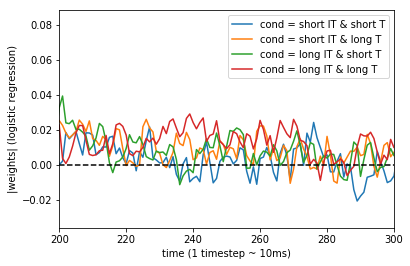

In [10]:
for cond in range(4):
    mov_average_value = 15
    weights = weights_fitted_subjects_avg[cond,:]
    weights_right = moving_average(weights[2,:],mov_average_value)
    weights_left = moving_average(weights[0,:],mov_average_value)
#     plt.plot(weights_right, label='cond = '+str(cond))
    plt.plot(weights_right, label='cond = '+str(conditions_names[cond]))
#     plt.plot(weights_left, label='left')
plt.legend()
plt.xlim(200,300)
plt.axhline(y=0,color='black',linestyle='--')
plt.xlabel('time (1 timestep ~ 10ms)')
plt.ylabel("|weights| (logistic regression)")
plt.show()

It seems that the orange and red weights decrease slower than blue and green. It would mean that the integration kernel is determined only by the length of the trial (and not on the inter-trial interval)